<a href="https://colab.research.google.com/github/MScEcologyAndDataScienceUCL/BIOS0032_AI4Environment/blob/main/02_Intro_to_ML/02_Intro_to_ML_Solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Week 2: Introduction to Machine Learning [Solutions]

In this week, we will get a hands-on experience with the fundamental concepts of Machine Learning
(ML)! 😃🤖

## Contents

0. [Introduction](#0-introduction)
1. [Data and Problem Statement](#1-data-and-problem-statement)
2. [Unsupervised Learning A: Clustering](#2-unsupervised-learning-a-clustering)
3. [Unsupervised Learning B: Dimensionality Reduction](#3-unsupervised-learning-b-dimensionality-reduction)
4. [Supervised Learning](#4-supervised-learning)
5. [Exercise: Putting it all Together](#5-exercise-putting-it-all-together)
6. [Regression](#6-regression)
7. [Conclusion](#7-conclusion)


## Notes

- If a line starts with the fountain pen symbol (🖌️), it asks you to implement a code part or
answer a question.
- Lines starting with the light bulb symbol (💡) provide important information or tips and tricks.

---

## 0. Introduction

Let us briefly recap the idea of machine learning:

> "ML is teaching computers how to perform a task without having to explicitly program them to do
> it."

To do so, we need the following ingredients:
* Task: for example, classifying species of butterflies in images
* Data: butterfly images (input), annotations of which species each image depicts (label)
* Model: a function that predicts our desired output based on the input

Our aim then is to train the model on given data to optimally fulfil the task.

Other examples that could be formulated as ML tasks:
* Predicting bat species from audio recordings
* Predicting bat behaviours from audio recordings
* Estimating the average global temperature from greenhouse gas emissions
* Mapping land cover from satellite imagery
* Predicting under which environmental conditions (temperature, precipitation, _etc._) we observe
  which species – we'll see this below.


Basically, any process where we can observe _relationships_ within data is a candidate for ML.
Whether or not ML makes sense, and which models do and do not, are completely different questions.


### 0.1 ML Workflow

Training an ML model involves the following steps:

![ml workflow](https://github.com/MScEcologyAndDataScienceUCL/BIOS0032_AI4Environment/blob/02_Intro_to_ML/ml_workflow.png?raw=true)

Notes:
* It's not a linear process, but an _iterative_ one: you usually have to go back multiple times to
  review what's happening.
* This is because you cannot expect an ML model to figure out everything by itself. It's no
  witchcraft, but simply an **exploitation of patterns** that correlate with what you want to
  predict.
* Related to this: ML models are only as good as the data (think about the last part of today's
  lecture). This also applies to the biggest deep learning models out there. Rubbish in, rubbish
  out.

Let's see it in action!

## 1. Data and Problem Statement

Today, we will learn, and apply, concepts of ML with application to **Species Distribution
Modelling (SDM)**.

Biotic species all have their _environmental niche_ – that is, an optimal combination of properties
of the world's surroundings that sustains the species across generations. For example, a polar bear
might need different temperatures than a Kookaburra, while a mountain goat can only be found in
rugged terrain. Oftentimes, it's a combination of factors that determines _habitat suitability_, and
SDMs try to predict this.

To do so, most SDMs take environmental conditions as input ("covariates") and are trained to predict
the presence/absence of a species based on observations. Cast into an ML framework, covariates are
our input features and observations our ground truth. Since we predict across multiple species and
have a target variable, we are performing **supervised classification**.



The dataset we'll be using in this exercise comes from the following paper:
> Winner, K., Ingenloff, K., Sandall, E., Sica, YV, Marsh, C., Cohen, J., Ranipeta, A., Killion, A.,
> Jetz, W.: _High Resolution Species Distribution Models of North American Biodiversity_. In
> preparation.

We'll be using a subset of ten mammalian species occurrences over North America.


Let us first load the _observations_. They come from GBIF
([10.15468/DL.ZP2JZF](https://www.gbif.org/occurrence/download/0291299-200613084148143)) and have
been pre-processed already, including removal of outliers and duplicates, and binning into $1km^2$
resolution grid cells.

In [ ]:
import pandas as pd

obs = pd.read_csv('https://raw.githubusercontent.com/MScEcologyAndDataScienceUCL/BIOS0032_AI4Environment/refs/heads/main/data/north_american_mammals/locations.csv')

obs.head()

lon        lat            species          id
0 -109.900000  49.583300  Lasiurus_cinereus  1414132141
1  -98.081754  19.694223  Lasiurus_cinereus  1418533465
2 -105.994193  25.955892  Lasiurus_cinereus  1422088335
3  -99.555278  18.591944  Lasiurus_cinereus  1418249950
4 -104.017754  25.278463  Lasiurus_cinereus  1422086748

Let's see how many species and how many data points per species we have:

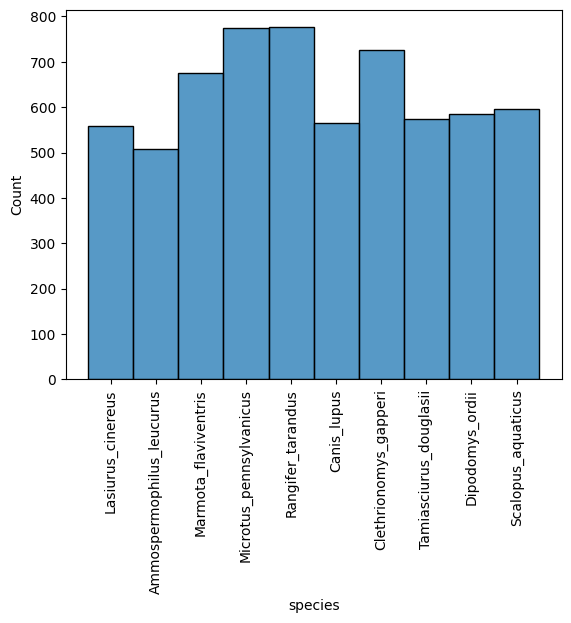

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(obs, x='species')
_ = plt.xticks(rotation=90)

We can visualise these points on a map, too!

In [5]:
import plotly.express as px

fig = px.scatter_mapbox(obs,
                        lat='lat',
                        lon='lon',
                        title='Observations',
                        hover_name='species',
                        color='species',
                        height=600,
                        width=800,
                        zoom=2)
fig.update_layout(mapbox_style='open-street-map')
fig.show()

What if we could predict where which species occurs, based on environmental conditions? That is the
key idea of an SDM!

But how do we measure, and represent, environmental conditions? And: which kinds of descriptors are
appropriate for the task?

This happens to be a challenge in itself, and I invite you to think about "right" and "wrong" ideas.
For now, let us load a few of them that have been prepared for you from the following sources:
* `meanAnnualTemp`: mean annual air temperature [CHELSA]
* `seasonalityPrecip`: precipitation seasonality [CHELSA]
* `accumPrecip`: accumulated precipitation on growing season days [CHELSA]
* `cloudCoverAnnualVar`: cloud cover intra-annual variation [EarthEnv]
* `topoRugged`: topographic ruggedness index [EarthEnv]
* `summerEVI`: mean summer EVI (Jun-Aug) [MODIS]
* `winterEVI`: mean winter EVI (Nov-Feb) [MODIS]

Sources:
* [CHELSA] https://chelsa-climate.org/
* [EarthEnv] https://www.earthenv.org/
* [MODIS] https://lpdaac.usgs.gov/products/mod13q1v006/

Let's load them:

In [6]:
# load covariates
cov = pd.read_csv('https://raw.githubusercontent.com/MScEcologyAndDataScienceUCL/BIOS0032_AI4Environment/refs/heads/main/data/north_american_mammals/covariates.csv')

# print first few rows
cov.head()

id  meanAnnualTemp  seasonalityPrecip  cloudCoverAnnualVar  \
0  1414132141          2771.0              554.0          1072.206177   
1  1418533465          2851.0              733.0          2087.228271   
2  1422088335          2863.0             1040.0          1751.061401   
3  1418249950          2934.0             1029.0          1398.814087   
4  1422086748          2959.0              938.0           823.457153   

   topoRugged    summerEVI    winterEVI  siltContent  clayContent  sandContent  
0   12.412183  3860.713379   965.195984   416.467102   261.975586   321.557312  
1   25.450399  3647.154541  2764.679199   301.668488   197.310333   501.021179  
2   38.998798  2666.125488  1870.845703   235.642242   274.923248   489.434509  
3   19.568239  4849.710449  2400.386230   231.096497   357.820496   411.083008  
4    1.363760  4358.366211  2182.718506   332.975037   240.049637   426.975342

You can see that both the covariates and observations have a column named `id` that is unique for
each data point. We can _join_ them together based on this field:

In [7]:
# merge (join) both data frames based on "id" column
data = pd.merge(obs, cov, on='id')

# remove invalid (NaN) values
data = data.dropna()

data.head()

# keep track of all covariate names
cov_cols = list(frozenset(cov.columns).difference(frozenset(['id', 'lon', 'lat', 'species'])))

# separate data into features (X) and labels (y)
X = data[cov_cols]
y = data['species']

💡 If you are curious how to extract these covariate values per location: we will learn about this
in Sessions 8 and 9.

We basically now have a dataset together that allows us to train, and evaluate, many types of ML
models!

Recall terminology from the lecture:
* Data point: a single row in the data frame
* $X$: features, descriptors, covariates (characteristics per data point of the environment)
* $y$: label, target, ground truth (here: species name, if we want to predict which one we observed)

Let's do some ML!

---

## 2. Unsupervised Learning A: Clustering

We will commence by taking a look at unsupervised learning. Here, our aim is to identify
**patterns** in the data $X$ without trying to predict a label – there is no $y$ (no species) here,
we only look at covariates.


Let us first visualise some of the features (covariates) in a scatter plot:

Output(outputs=({'output_type': 'display_data', 'data': {'text/plain': "Dropdown(description='x Axis:', option…

<Figure size 640x480 with 0 Axes>

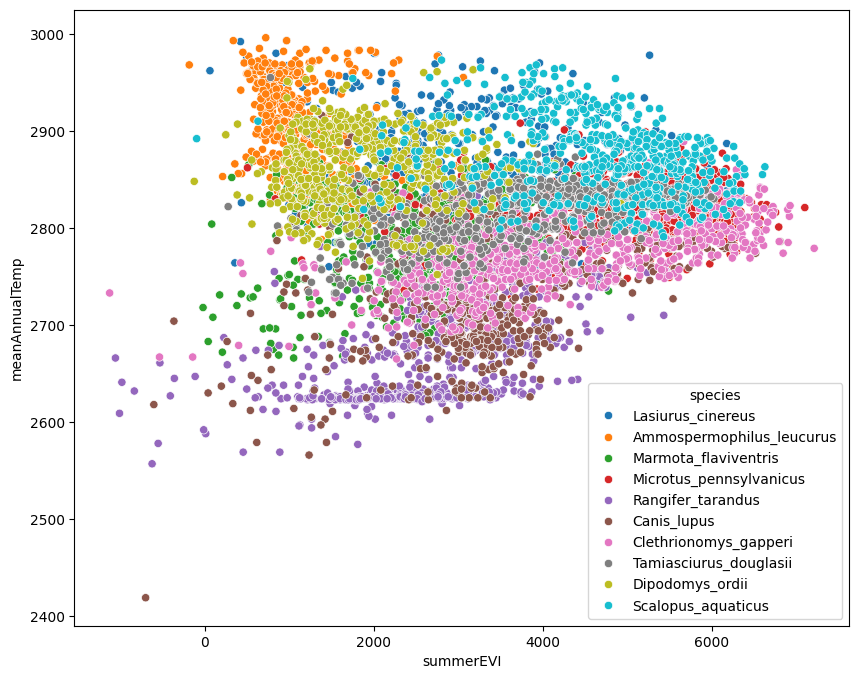

In [8]:
# just run this code cell, but otherwise ignore it (no need to understand what's going on)

import ipywidgets as widgets
from IPython.display import display, clear_output


def plot_feature_space(dataframe,
                       axis_names=cov_cols,
                       colour_by='species'):
    w_x = widgets.Dropdown(description='x Axis:', options=axis_names, value=axis_names[0])
    w_y = widgets.Dropdown(description='y Axis:', options=axis_names, value=axis_names[1])
    w_c = None
    if not isinstance(colour_by, str):
        w_c = widgets.Dropdown(description='colour by:', options=colour_by, value=colour_by[-1])

    def onchange(_):
        plt.clf()
        plt.figure(figsize=(10,8))
        clear_output(wait=False)
        out = widgets.Output()
        out.append_display_data(w_x)
        out.append_display_data(w_y)
        if w_c is not None:
            out.append_display_data(w_c)
            hue = w_c.value
        else:
            hue = colour_by
        sns.scatterplot(dataframe,
                        x=w_x.value,
                        y=w_y.value,
                        hue=hue)
        display(out)

    w_x.observe(onchange)
    w_y.observe(onchange)
    if w_c is not None:
        w_c.observe(onchange)
    onchange(None)

plot_feature_space(data)

🖌️ Play around with the two dropdown menus to visualise different combinations of features
(covariates).

Can you already see some patterns?

Perhaps there are combinations of features that are better suited to discriminate between species
than others?

Is there a combination of two features that allows full separation of all species?

### 2.1 k-Means

A first type of unsupervised learning is clustering, where we try to find **natural groupings** in
the data. This is useful for many types of tasks, such as data exploration and sanity checks (for
example, we would expect species living in similar environments to be close together in _feature
space_).

There are multiple ways to do so, but the most typical algorithm is called $k$-Means.

🖌️ Read up Scikit-learn's [k-Means implementation
documentation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) and
see how it works. Take a particular look at the "Examples" section and the methods it offers.

In [9]:
from sklearn.cluster import KMeans

# initiate new clustering algorithm
k_means = KMeans(n_clusters=5)

# fit model to data
k_means.fit(X)

# predict cluster assignments
y_pred = k_means.predict(X)

A few things have happened in the code cell above:
1. We imported the k-Means algorithm implementation from scikit-learn.
2. Next, we created a new k-Means _instance_ (`k_means = ...`) and defined how it should behave.
   That instance has not yet seen any of our data, though.
3. We then _fit_ the model to our data, `X`. Here is where the **learning** takes place!
4. Finally, our model has learnt the clusters of our data, so we can use it to obtain
   **predictions**. More specifically, by calling the `.predict()` function, we can feed it with
   data points of the same type of features and the model will return which of its clusters each
   data point belongs to.

You will see down below that all Scikit-learn models operate along very similar principles.

We can now visualise cluster assignments in _feature space_...

Output(outputs=({'output_type': 'display_data', 'data': {'text/plain': "Dropdown(description='x Axis:', option…

<Figure size 640x480 with 0 Axes>

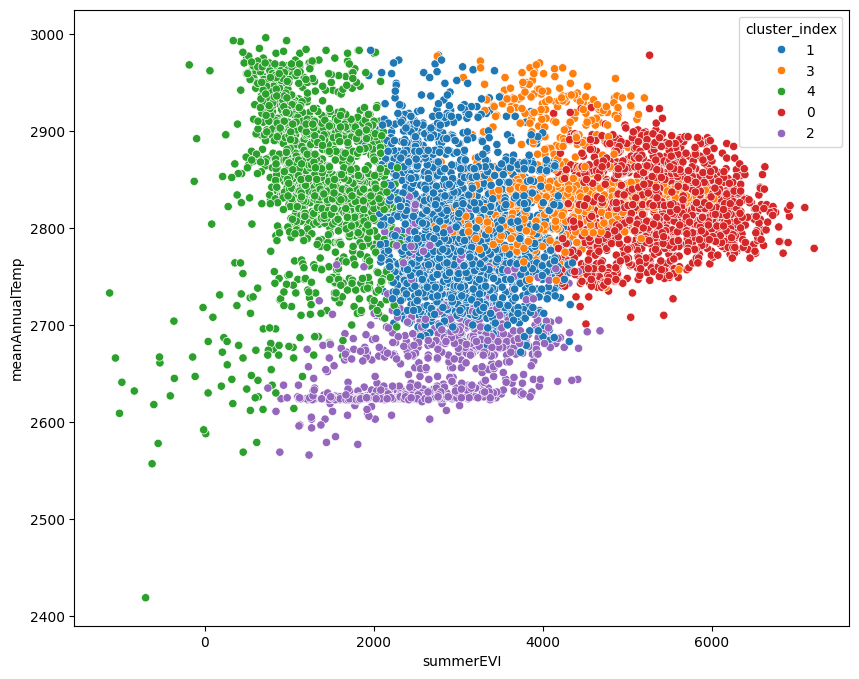

In [10]:
pred_kmeans = data.copy()
pred_kmeans['cluster_index'] = y_pred.astype(str)

plot_feature_space(pred_kmeans, colour_by=['species', 'cluster_index'])

...and in geographic space:

In [11]:
# visualise cluster assignments in geographic space
fig = px.scatter_mapbox(pred_kmeans,
                        lat='lat',
                        lon='lon',
                        title='Observations clustered',
                        hover_name='species',
                        color='cluster_index',
                        height=600,
                        width=800,
                        zoom=2)
fig.update_layout(mapbox_style='open-street-map')
fig.show()

Did that work well? Can you now see some patterns in either feature and/or geographic space? Why,
respectively why not?


#### Hyperparameters

Recall from the lecture what a hyperparameter is: a property of the ML algorithm that is not learnt
from the data $X$ itself, _i.e._, we set it _by hand_.

$k$-Means has one key hyperparameter: $k$, the number of clusters.

🖌️ Go back up and change this hyperparameter down and up. What happens? Is there an optimum?

There are many other clustering algorithms available, including some which try to estimate the
optimal number of clusters from the data. Make sure to check out [clustering algorithms in
Scikit-learn](https://scikit-learn.org/stable/api/sklearn.cluster.html).

---

## 3. Unsupervised Learning B: Dimensionality Reduction

From the scatter plots above, you can see that they quickly become unwieldy: we can only
realistically visualise two covariates at the same time, three already can become quite ambiguous.
However, the clustering exercise showed us that data points tend to be grouped together somewhat.
Wouldn't it be great if we could "compress" all of these patterns into just a few, say two,
dimensions that represent points in their feature space distance more visibly?

This is exactly what dimensionality reduction tries to achieve!

It's a useful technique for visualisation, but sometimes also for pre-processing of features, in
cases where there are too many of them for a downstream model to process.


### 3.1 PCA

The first dimensionality reduction method we will take a look at is **Principal Component Analysis
(PCA)**. PCA applies a _linear transformation_, a _rotation_ of the feature space, so that the first
_component_ contains as much of the variance as possible.

Let's first start with a toy example. Suppose we have data as follows:

(-3.0, 3.0)

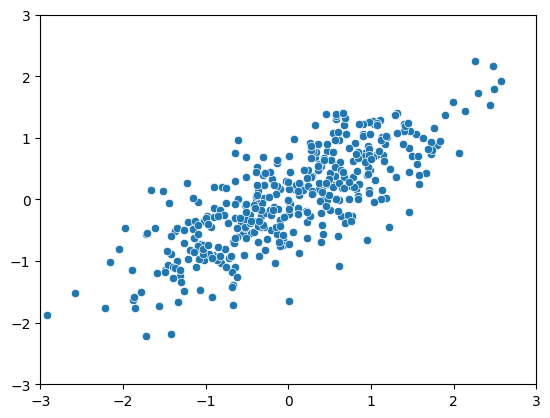

In [12]:
import numpy as np

x1 = np.random.randn(400)
x2 = 0.7*x1 + 0.5 * np.random.randn(400)

ax = sns.scatterplot(x=x1, y=x2)
ax.set_xlim([-3, 3])
ax.set_ylim([-3, 3])

Watch what happens when we apply PCA to these two features:

(-3.0, 3.0)

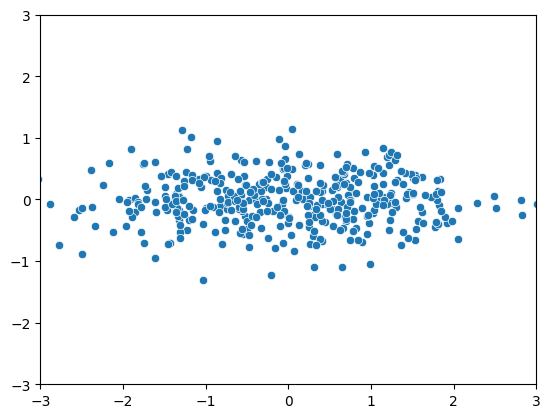

In [13]:
# import PCA from scikit-learn
from sklearn.decomposition import PCA

# combine the two toy features
toy_data = np.stack((x1, x2), 1)

# fit a PCA and transform the data to obtain principal components
pca = PCA().fit(toy_data)
components = pca.transform(toy_data)

# visualise the two principal components
ax = sns.scatterplot(x=components[:,0],
                     y=components[:,1])
ax.set_xlim([-3, 3])
ax.set_ylim([-3, 3])

Suddenly, all the data points are distributed along the first (x) axis. In other words, the first
component captures most of the variance! Their _relative_ distribution is still the same.

By default, PCA returns as many components as there are dimensions in the data. However, what often
happens under very high-dimensional data is that the first few components contain all of the
variance (information), while the remaining ones only capture residual noise. Let's see this in
action on our environmental covariates from above.

In [14]:
# create new PCA object
pca = PCA().fit(X)
components = pca.transform(X)

Output(outputs=({'output_type': 'display_data', 'data': {'text/plain': "Dropdown(description='x Axis:', option…

<Figure size 640x480 with 0 Axes>

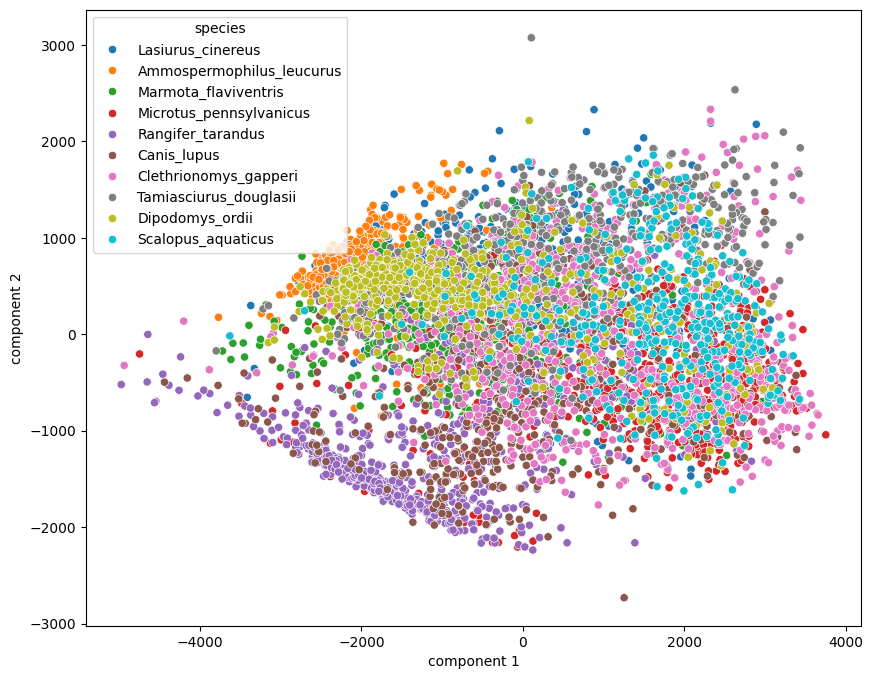

In [15]:
colnames = [f'component {c+1}' for c in range(X.shape[1])]

if not isinstance(components, pd.DataFrame):
    components = pd.DataFrame(components, columns=colnames)
    components['species'] = data['species']

plot_feature_space(components, colnames)

PCA also calculates how much of the data's variance each principal component explains. We can plot
this in descending order, from the first to the last component. This is called a **Scree plot**:

Text(0, 0.5, 'Explained variance')

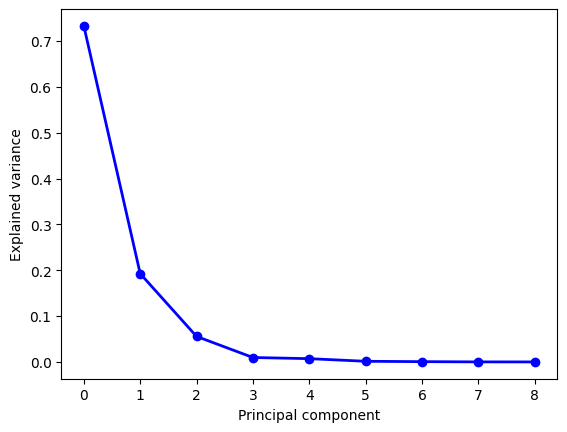

In [16]:
plt.plot(range(X.shape[1]), pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.xlabel('Principal component')
plt.ylabel('Explained variance')

Notice a little bit of an "elbow" near the third to fourth PC? It's not as pronounced here, but this
is usually where you'd make a cut – you would only use the first $n$ PCs up until this point for
further analyses, as all the remaining ones mostly contain only noise.

### 3.2 t-SNE

As you have seen above, PCA was only somewhat able to condense the data variation effectively. We
still see a lot of variance beyond the first two components, so clearly, PCA isn't as effective as
could be for this dataset.

The reason for this is that our environmental conditions show **non-linear interactions**. Remember
that PCA just applies a rotation (see toy example)? That is a linear transformation; therefore, it
doesn't suffice to represent our data properly. In some sense, PCA _underfits_ our data (yes, even
unsupervised models can do that!). What can we do instead?


There are in fact dimensionality reduction methods that operate non-linearly. The first one we will
take a look at is called **t-Stochastic Neighbour Embedding (t-SNE)**. This works by representing
data points on the Student-t distribution. Checkout the
[paper](https://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf) where t-SNE was
introduced, or this [blog](https://distill.pub/2016/misread-tsne/) for further information.


Let's see what happens:

In [17]:
# import t-SNE mapping from scikit-learn
from sklearn.manifold import TSNE

# use t-SNE to project data to two dimensions
tsne = TSNE(n_components=2,
            init='pca',
            learning_rate='auto')
dimensions = tsne.fit_transform(X)

Output(outputs=({'output_type': 'display_data', 'data': {'text/plain': "Dropdown(description='x Axis:', option…

<Figure size 640x480 with 0 Axes>

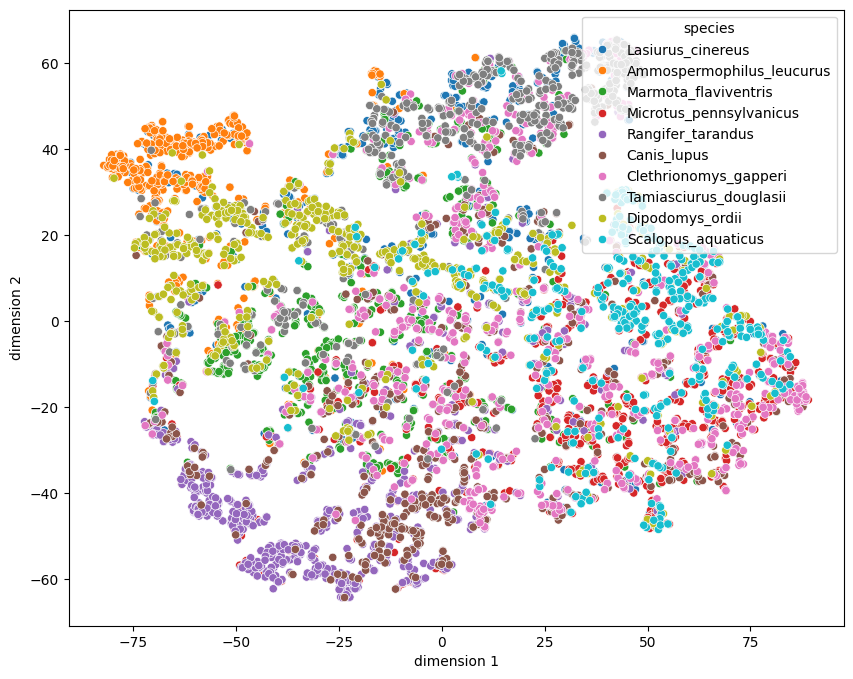

In [18]:
colnames = [f'dimension {c+1}' for c in range(dimensions.shape[1])]

if not isinstance(dimensions, pd.DataFrame):
    dimensions = pd.DataFrame(dimensions, columns=colnames)
    dimensions['species'] = data['species']

plot_feature_space(dimensions, colnames)

Can you separate the data more clearly?

Well, we can see some really interesting patterns, but it's not perfect.


### 3.3 UMAP

Let's try another method, Uniform Manifold Approximation and Projectin (UMAP). For this, we need to
install the [umap-learn](https://umap-learn.readthedocs.io/en/latest/index.html) library first:

In [19]:
%pip install umap-learn

Note: you may need to restart the kernel to use updated packages.


Output(outputs=({'output_type': 'display_data', 'data': {'text/plain': "Dropdown(description='x Axis:', option…

<Figure size 640x480 with 0 Axes>

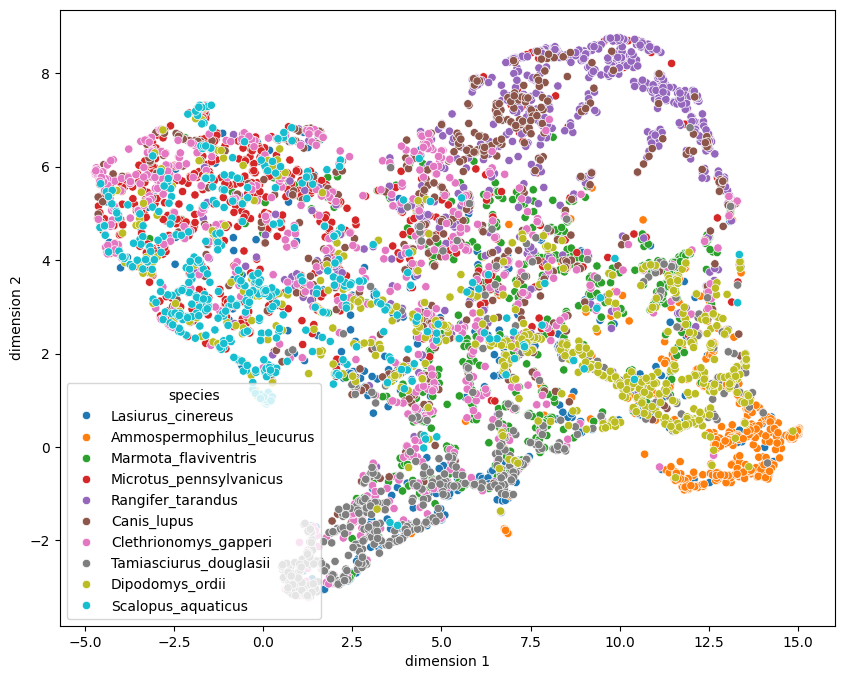

In [20]:
from umap import UMAP

dimensions = UMAP(n_components=2).fit_transform(X)

colnames = [f'dimension {c+1}' for c in range(dimensions.shape[1])]

if not isinstance(dimensions, pd.DataFrame):
    dimensions = pd.DataFrame(dimensions, columns=colnames)
    dimensions['species'] = data['species']

plot_feature_space(dimensions, colnames)

That looks different, but it's still not good.

One reason we don't see good separation often is because methods like t-SNE and UMAP (and many other
ML ones, especially deep learning) are influenced by the **magnitude of covariates**: if one
covariate has particularly big positive and/or negative values, relative to the others, it can
dominate the signal and bias the model.

Luckily, we can resolve this problem through **data normalisation**. One of the most common means to
do so is called **z-scoring**, and it works as follows:

$$\hat{x} = \frac{x - mean(x)}{std(x)}$$

Scikit-learn provides utilities to do that:

In [21]:
# import the StandardScaler from scikit-learn preprocessing module
from sklearn.preprocessing import StandardScaler

# standardise the data
X_norm = StandardScaler().fit_transform(X)

Let's apply UMAP again:

Output(outputs=({'output_type': 'display_data', 'data': {'text/plain': "Dropdown(description='x Axis:', option…

<Figure size 640x480 with 0 Axes>

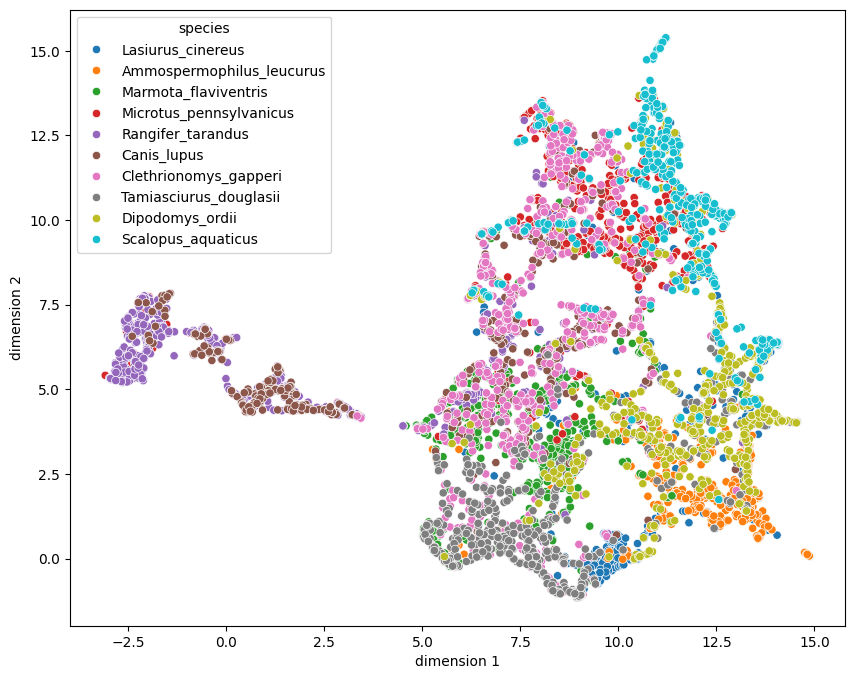

In [22]:
dimensions = UMAP(n_components=2).fit_transform(X_norm)

colnames = [f'dimension {c+1}' for c in range(dimensions.shape[1])]

if not isinstance(dimensions, pd.DataFrame):
    dimensions = pd.DataFrame(dimensions, columns=colnames)
    dimensions['species'] = data['species']

plot_feature_space(dimensions, colnames)

Still not perfect, but better! We can start to see discernible clusters of species.

This tells us that we can probably proceed with trying to predict which species has been observed
under which feature combination. Since non-linear methods gave us the best results, it seems likely
that we will also need a non-linear classifier to do so.

### 3.4 Summary: Unsupervised Learning

Unsupervised methods come in handy to get a first overview of the data, to preprocess it, and to
identify patterns. They are thus very popular for exploratory analyses, including inference.

But of course, they also have their limits. Any _semantic meaning_ you wish to assign to the data,
such as a label class (species), can almost never be realistically uncovered by any of them.


---

## 4. Supervised Learning

We have had an extensive look at our covariates (features) above. We have seen that some of the
species tend to form clusters and are, to some degree, separable in our high-dimensional feature
space. This is a good starting point, because it means that we can possibly learn to _exploit_ these
_patterns_ in the data to predict a semantic concept: the species we have observed at each location.

Enter: supervised learning. Now, we also have a **ground truth** (target, $y$) that we want to
predict.

### 4.1 Concepts

Let us first take a look at the task of supervised learning itself. For simplification and
visualisation reasons, we will subset our data above to:
1. Two species, the White-tailed antelope squirrel (_Ammospermophilus leucurus_) and the Reindeer
   (_Rangifer tarandus_).
2. Two covariates, mean annual temperature and precipitation seasonality.

Output(outputs=({'output_type': 'display_data', 'data': {'text/plain': "Dropdown(description='x Axis:', option…

<Figure size 640x480 with 0 Axes>

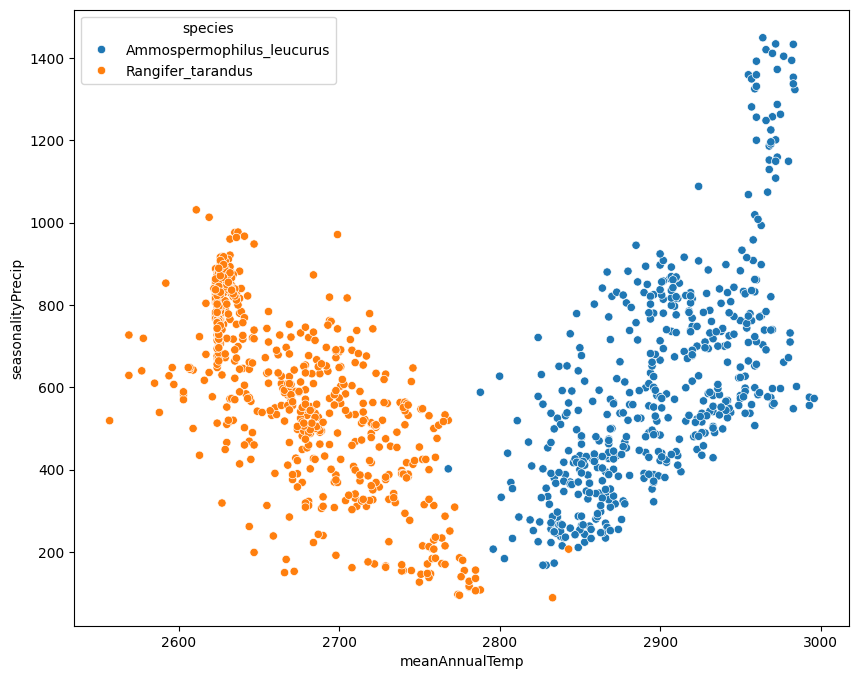

In [23]:
species_subset = ['Ammospermophilus_leucurus', 'Rangifer_tarandus']
covs_subset = ['meanAnnualTemp', 'seasonalityPrecip']

data_subset = data[covs_subset + ['lat', 'lon', 'species']]
data_subset = data_subset[data_subset['species'].isin(species_subset)]

X_subset = data_subset[covs_subset]
y_subset = data_subset['species']

plot_feature_space(data_subset, covs_subset)

That looks suspiciously... _separable_.

Remember the key objective of a supervised model? It's prediction: given a new data point with
covariate values, we want to predict which species has been observed there based on the experience
(training data) we have, _i.e._, our observations and covariate values shown in the plot above.

Let's add a new, previously unseen point to demonstrate this:

Output(outputs=({'output_type': 'display_data', 'data': {'text/plain': "Dropdown(description='x Axis:', option…

Text(2820.0, 980.0, 'test point')

<Figure size 640x480 with 0 Axes>

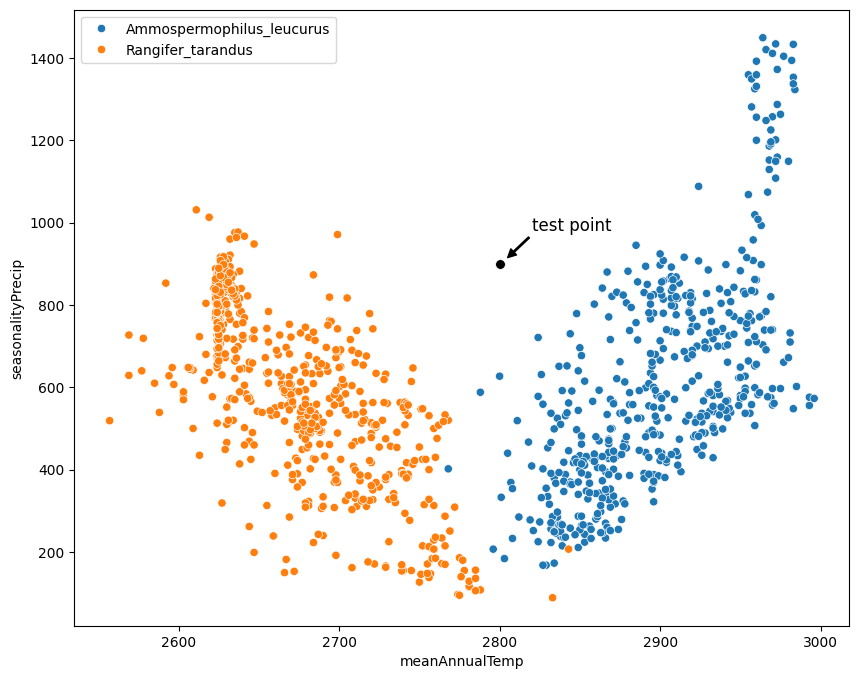

In [24]:
# define a new test point with given covariate values
test_point = pd.DataFrame({'meanAnnualTemp': [2800.0], 'seasonalityPrecip': [900.0]})


plot_feature_space(data_subset, covs_subset)
ax = sns.scatterplot(test_point, x='meanAnnualTemp', y='seasonalityPrecip', color='k', s=50)
ax.annotate('test point',
            (test_point.values[0,0] + 5, test_point.values[0,1] + 15),
            xytext=(test_point.values[0,0] + 20, test_point.values[0,1] + 80),
            fontsize=12,
            color='k',
            arrowprops={
                "width": 1,
                "headwidth": 6,
                "headlength": 6,
                "edgecolor": 'k',
                "facecolor": 'k',
            })

### 4.2 $k$-Nearest Neighbour

The first supervised classifier we will take a look at should be familiar to you from the lecture:
$k$-Nearest Neighbour.

As you have seen and the name suggests, it is based on finding the training points that are closest
in feature space to our test point. To do so, we need to perform the following steps:
1. Calculate distances between all training points and the test point.
2. Select the top-$k$ training points with _smallest distance_.
3. Assign label: most frequent training label (mode).


First, let's think about distance. This should tell us, numerically, how similar two points are in
feature space. The first and most intuitive idea is to use the _Euclidean_ distance (based on the
Pythagorean theorem):

![euclidean distance](https://upload.wikimedia.org/wikipedia/commons/5/55/Euclidean_distance_2d.svg)

<Axes: xlabel='meanAnnualTemp', ylabel='seasonalityPrecip'>

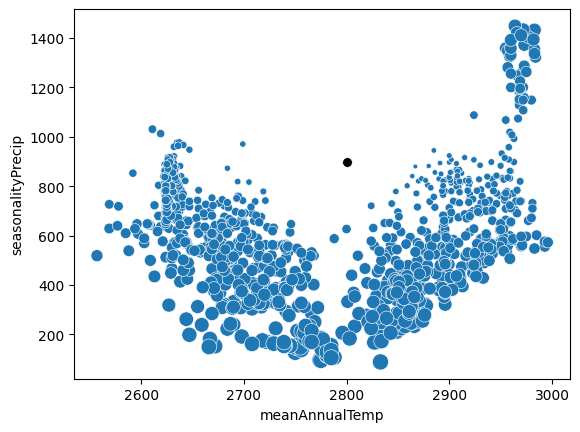

In [25]:
import numpy as np

dist = np.sqrt(np.sum((X_subset.values - test_point[covs_subset].values)**2, 1))


# scatter plot with point sizes depending on their distance to test point
sns.scatterplot(data_subset,
                x=covs_subset[0],
                y=covs_subset[1],
                s=dist/6)
sns.scatterplot(test_point, x='meanAnnualTemp', y='seasonalityPrecip', color='k', s=50)


Let's find the closest training point: it's the one with minimum distance to the test point, or
mathematically speaking, the "argument of the minimum" ($\arg\min$):

Output(outputs=({'output_type': 'display_data', 'data': {'text/plain': "Dropdown(description='x Axis:', option…

Text(2787.0, 1000.0, 'closest point')

<Figure size 640x480 with 0 Axes>

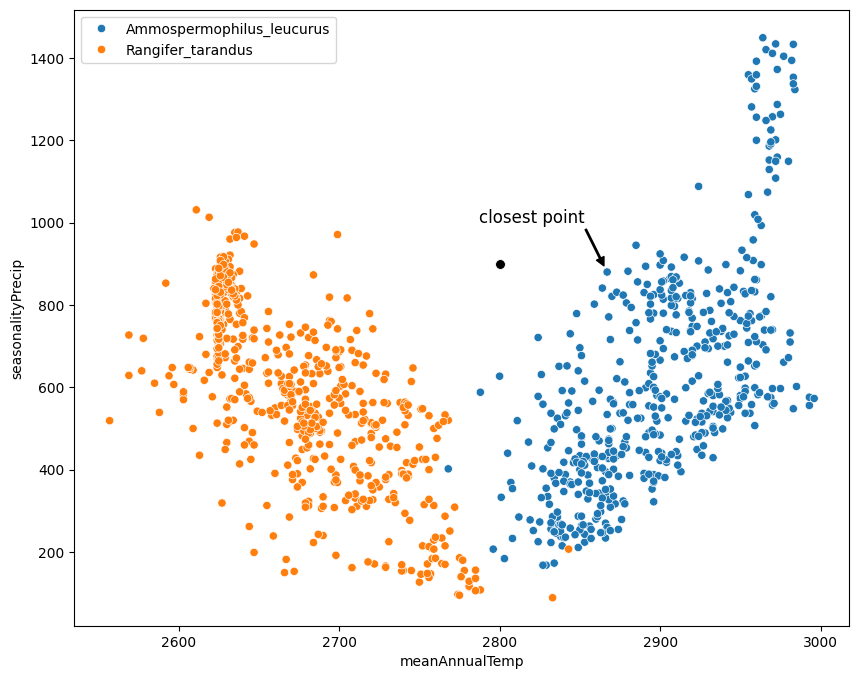

In [26]:
closest_point_index = np.argmin(dist)
closest_point = X_subset.iloc[closest_point_index].values

# visualise the closest point
plot_feature_space(data_subset, covs_subset)
ax = sns.scatterplot(test_point, x='meanAnnualTemp', y='seasonalityPrecip', color='k', s=50)
ax.annotate('closest point',
            (closest_point[0]-2, closest_point[1] + 15),
            xytext=(closest_point[0] - 80, closest_point[1] + 120),
            fontsize=12,
            color='k',
            arrowprops={
                "width": 1,
                "headwidth": 6,
                "headlength": 6,
                "edgecolor": 'k',
                "facecolor": 'k',
            })

That looks fair enough. With just this one point, the predicted label thus is the one of this
closest point:

In [27]:
y_hat = y_subset.iloc[closest_point_index]
print(f'Predicted label: {y_hat}.')

Predicted label: Ammospermophilus_leucurus.


💡 We don't necessarily have to use Euclidean distance. Some feature spaces might be more easily
separable with other metrics. See the [scikit-learn
documentation](https://scikit-learn.org/1.5/modules/generated/sklearn.metrics.DistanceMetric.html)
for other examples.

Let's try another point:

Output(outputs=({'output_type': 'display_data', 'data': {'text/plain': "Dropdown(description='x Axis:', option…

Text(2870.0, 200.0, 'test point')

<Figure size 640x480 with 0 Axes>

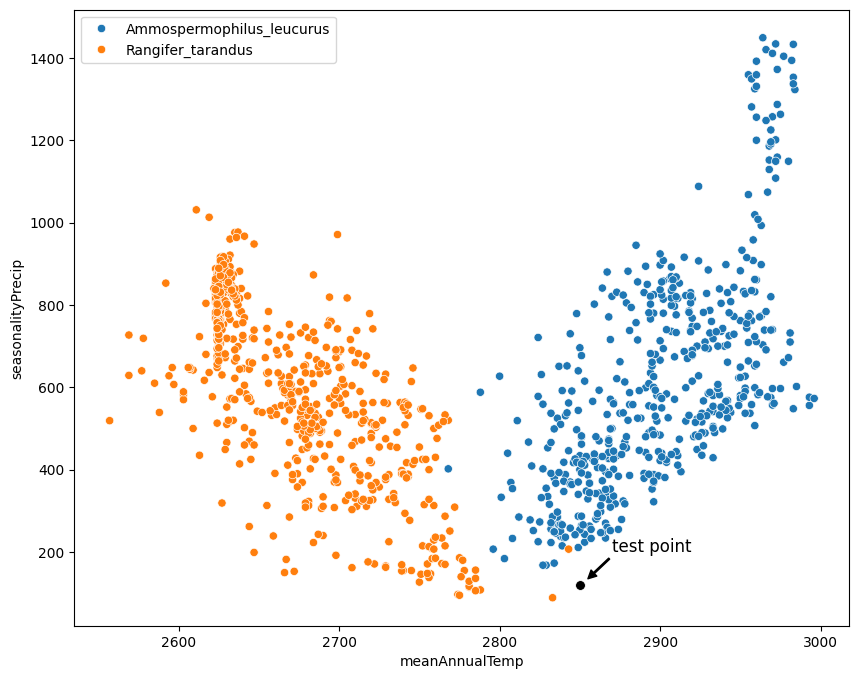

In [28]:
# second test point
test_point_2 = pd.DataFrame({'meanAnnualTemp': [2850.0], 'seasonalityPrecip': [120.0]})


plot_feature_space(data_subset, covs_subset)
ax = sns.scatterplot(test_point_2, x='meanAnnualTemp', y='seasonalityPrecip', color='k', s=50)
ax.annotate('test point',
            (test_point_2.values[0,0] + 5, test_point_2.values[0,1] + 15),
            xytext=(test_point_2.values[0,0] + 20, test_point_2.values[0,1] + 80),
            fontsize=12,
            color='k',
            arrowprops={
                "width": 1,
                "headwidth": 6,
                "headlength": 6,
                "edgecolor": 'k',
                "facecolor": 'k'
            })

Can you guess what will happen here?

In [29]:
dist_2 = np.sqrt(np.sum((X_subset.values - test_point_2[covs_subset].values)**2, 1))

closest_point_index_2 = np.argmin(dist_2)
closest_point_2 = X_subset.iloc[closest_point_index_2].values

y_hat_2 = y_subset.iloc[closest_point_index_2]
print(f'Predicted label for second test point: {y_hat_2}.')

Predicted label for second test point: Rangifer_tarandus.


That does not seem right.

Sure, the closest point in our training set has label _Rangifer tarandus_ – but it's the only one in
quite a distance. What if this is a measurement or data error?

You can see a problem with nearest neighbour right away: it's very susceptible to **noise** in the
data. Then again, this training point could very well be a real one if the data isn't as separable
as we hoped (_cf._ unsupervised learning part above). What can we do in this case?


A first idea is to take more training samples into account when taking a decision. If you have
guessed that this pertains to the $k$ in $k$-Nearest Neighbour, you are 100% right! If we take the
top-$k$ instead of just the top-1 closest training point into account, we can "iron out" any small
errors and artefacts in the dataset and possibly obtain a better-informed decision.

We can do so by sorting the distances in ascending order and literally taking the first $k$
elements:

Output(outputs=({'output_type': 'display_data', 'data': {'text/plain': "Dropdown(description='x Axis:', option…

<Axes: xlabel='meanAnnualTemp', ylabel='seasonalityPrecip'>

<Figure size 640x480 with 0 Axes>

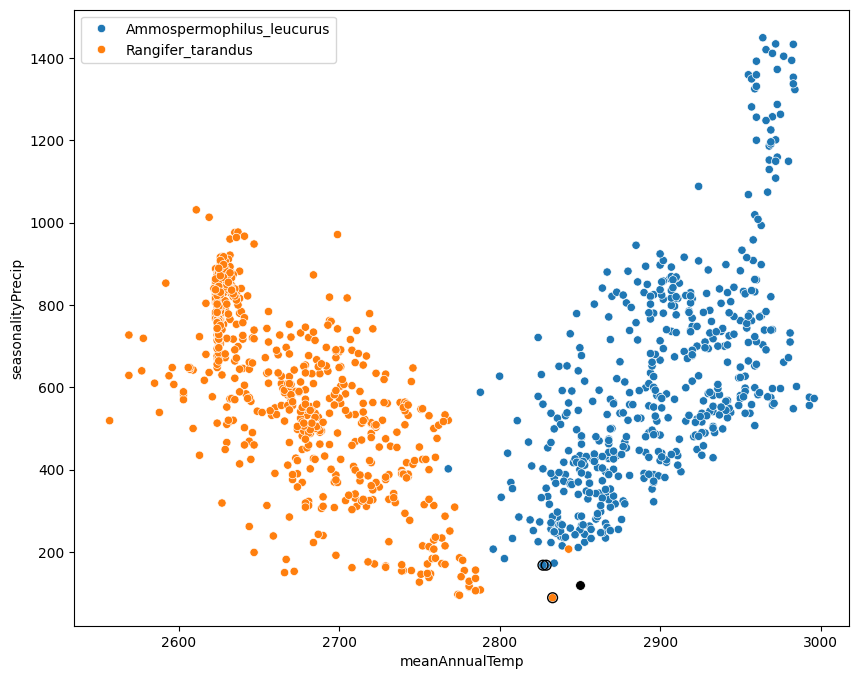

In [30]:
# set k in advance (hyperparameter!)
k = 3


# sort distances. We're not interested in the distance values at this point, only the index of the
# top-k points, so we can directly use NumPy's argsort function
dist_2_indices = np.argsort(dist_2)

# take the top-k
closest_point_indices_topk = dist_2_indices[:k]
closest_points_topk = data_subset.iloc[closest_point_indices_topk]

# plot
plot_feature_space(data_subset, covs_subset)
sns.scatterplot(test_point_2, x='meanAnnualTemp', y='seasonalityPrecip', color='k', s=50)
sns.scatterplot(closest_points_topk, x='meanAnnualTemp', y='seasonalityPrecip', facecolor='none', edgecolor='k', linewidth=1, s=50)

Then, the predicted label becomes the mode of the top-$k$ closest points:

In [31]:
y_hat_topk = closest_points_topk['species'].mode().values[0]

print(f'Predicted label for k={k}: {y_hat_topk}')

Predicted label for k=3: Ammospermophilus_leucurus


That looks better!

Scikit-learn has an implementation of $k$-Nearest Neighbour available for us to use:

In [32]:
from sklearn.neighbors import KNeighborsClassifier

# create a model instance
knn = KNeighborsClassifier(n_neighbors=k)

# fit model with data
knn.fit(X_subset, y_subset)

# predict test point
y_hat_2_sklearn = knn.predict(test_point_2)

print(f'Predicted label for k={k} by scikit-learn implementation: {y_hat_2_sklearn[0]}')

Predicted label for k=3 by scikit-learn implementation: Ammospermophilus_leucurus


With the official implementation, we can also visualise its **decision boundary**.

The following code cell does that – you don't need to understand how this works, just run it so that
we have the function ready.

In [90]:
import numpy as np
from matplotlib.colors import ListedColormap


def _is_arraylike_not_scalar(array):
    return _is_arraylike(array) and not np.isscalar(array)


def _check_boundary_response_method(estimator, response_method):
    has_classes = hasattr(estimator, "classes_")
    if has_classes and _is_arraylike_not_scalar(estimator.classes_[0]):
        msg = "Multi-label and multi-output multi-class classifiers are not supported"
        raise ValueError(msg)

    if has_classes and len(estimator.classes_) > 2:
        if response_method not in {"auto", "predict"}:
            msg = (
                "Multiclass classifiers are only supported when response_method is"
                " 'predict' or 'auto'"
            )
            raise ValueError(msg)
        methods_list = ["predict"]
    elif response_method == "auto":
        methods_list = ["decision_function", "predict_proba", "predict"]
    else:
        methods_list = [response_method]

    prediction_method = [getattr(estimator, method, None) for method in methods_list]
    prediction_method = reduce(lambda x, y: x or y, prediction_method)
    if prediction_method is None:
        raise ValueError(
            f"{estimator.__class__.__name__} has none of the following attributes: "
            f"{', '.join(methods_list)}."
        )

    return prediction_method


def plot_decision_boundary(
    estimator,
    X,
    *,
    grid_resolution=100,
    eps=1.0,
    plot_method="contourf",
    response_method="auto",
    xlabel=None,
    ylabel=None,
    ax=None,
    **kwargs,
):
    if not grid_resolution > 1:
        raise ValueError(
            "grid_resolution must be greater than 1. Got" f" {grid_resolution} instead."
        )

    if not eps >= 0:
        raise ValueError(f"eps must be greater than or equal to 0. Got {eps} instead.")

    possible_plot_methods = ("contourf", "contour", "pcolormesh")
    if plot_method not in possible_plot_methods:
        available_methods = ", ".join(possible_plot_methods)
        raise ValueError(
            f"plot_method must be one of {available_methods}. "
            f"Got {plot_method} instead."
        )

    num_features = _num_features(X)
    if num_features != 2:
        raise ValueError(f"n_features must be equal to 2. Got {num_features} instead.")

    x0, x1 = _safe_indexing(X, 0, axis=1), _safe_indexing(X, 1, axis=1)

    x0_min, x0_max = x0.min() - eps, x0.max() + eps
    x1_min, x1_max = x1.min() - eps, x1.max() + eps

    xx0, xx1 = np.meshgrid(
        np.linspace(x0_min, x0_max, grid_resolution),
        np.linspace(x1_min, x1_max, grid_resolution),
    )

    if hasattr(X, "iloc"):
        # we need to preserve the feature names and therefore get an empty dataframe
        X_grid = X.iloc[[], :].copy()
        X_grid.iloc[:, 0] = xx0.ravel()
        X_grid.iloc[:, 1] = xx1.ravel()
    else:
        X_grid = np.c_[xx0.ravel(), xx1.ravel()]

    pred_func = _check_boundary_response_method(estimator, response_method)
    response = pred_func(X_grid)

    # convert classes predictions into integers
    if pred_func.__name__ == "predict" and hasattr(estimator, "classes_"):
        encoder = LabelEncoder()
        encoder.classes_ = estimator.classes_
        response = encoder.transform(response)

    if response.ndim != 1:
        if is_regressor(estimator):
            raise ValueError("Multi-output regressors are not supported")

        # TODO: Support pos_label
        response = response[:, 1]

    if xlabel is None:
        xlabel = X.columns[0] if hasattr(X, "columns") else ""

    if ylabel is None:
        ylabel = X.columns[1] if hasattr(X, "columns") else ""

    if plot_method not in ("contourf", "contour", "pcolormesh"):
        raise ValueError("plot_method must be 'contourf', 'contour', or 'pcolormesh'")

    if ax is None:
        _, ax = plt.subplots()

    plot_func = getattr(ax, plot_method)

    surface_ = plot_func(xx0, xx1, response.reshape(xx0.shape), **kwargs)

    if xlabel is not None or not ax.get_xlabel():
        xlabel = xlabel if xlabel is None else xlabel
        ax.set_xlabel(xlabel)

    if ylabel is not None or not ax.get_ylabel():
        ylabel = ylabel if ylabel is None else ylabel
        ax.set_ylabel(ylabel)

    return ax

cmap_light = ListedColormap(["lightblue", "peachpuff"])

<Axes: xlabel='meanAnnualTemp', ylabel='seasonalityPrecip'>

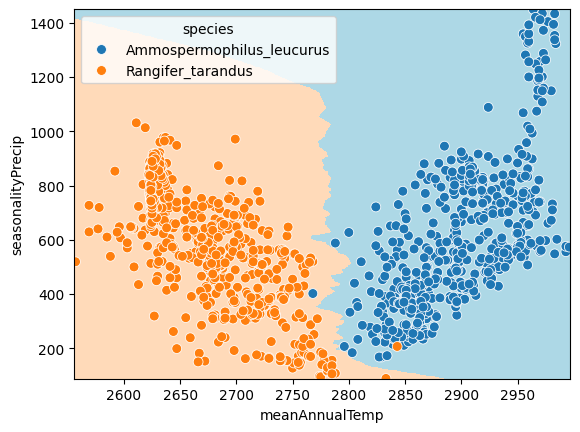

In [91]:
plot_decision_boundary(knn, data_subset[covs_subset], cmap=cmap_light, grid_resolution=500)
sns.scatterplot(data_subset, x='meanAnnualTemp', y='seasonalityPrecip', hue='species', s=50)

$k$-Nearest Neighbour can be very powerful, but it suffers from some problems.

🖌️ Can you name them?

_Solution_

Problems of $k$-Nearest Neighbour:
* Sensitivity to errors in the data: as soon as a single training point's label is incorrect, it
  might give totally wrong predictions (especially if $k$ is low).
* Overconfidence: it will always yield a prediction, even for points that are far outside the
  sensible value ranges of features (and might belong to another species...).
* Cost: the prediction cost of $k$-Nearest Neighbour scales linearly with the number of training
  points, because more and more pairwise distances need to be computed. At some point, this becomes
  extremely expensive, not just in terms of computation cycles (time), but also memory footprint.
* No probabilities: we can't easily get confidence scores from the model (well, there are some
  approximations, but they are a bit ad-hoc).

### 4.3 Decision Tree

Let's add a third species into the mix to make this one more interesting: the Eastern mole
(_Scalopus aquaticus_).

Output(outputs=({'output_type': 'display_data', 'data': {'text/plain': "Dropdown(description='x Axis:', option…

<Figure size 640x480 with 0 Axes>

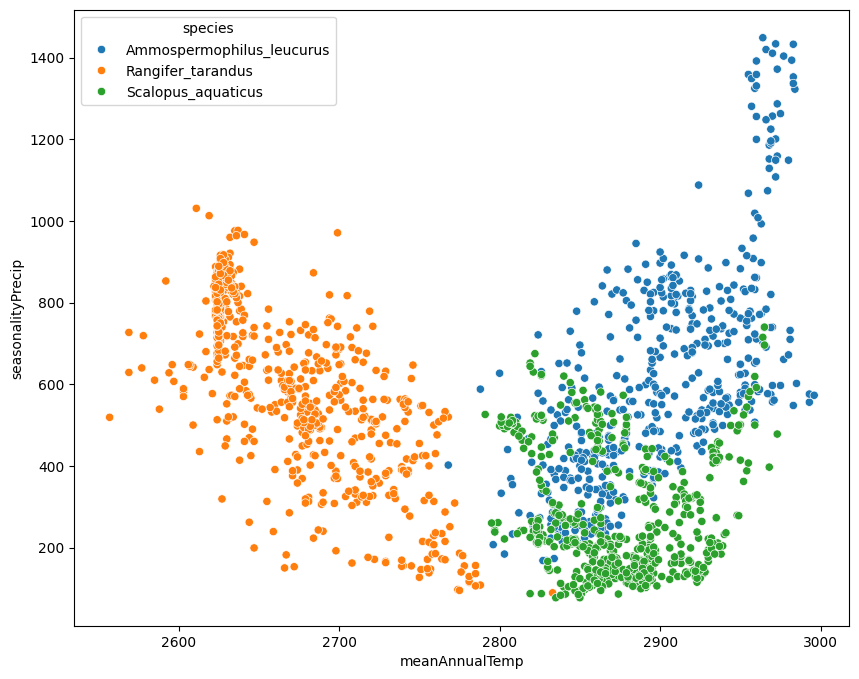

In [93]:
species_subset = ['Ammospermophilus_leucurus', 'Rangifer_tarandus', 'Scalopus_aquaticus']
covs_subset = ['meanAnnualTemp', 'seasonalityPrecip']

data_subset = data[covs_subset + ['lat', 'lon', 'species']]
data_subset = data_subset[data_subset['species'].isin(species_subset)]

X_subset = data_subset[covs_subset]
y_subset = data_subset['species']

plot_feature_space(data_subset, covs_subset)

Now that looks a bit harder!

We could theoretically use $k$-Nearest Neighbour just as we did before with only two species.
However, let us instead look at another idea: the **decision tree**.

Here, we recursively split the feature space along one of its dimensions to _partition_ it. For
example, we can easily separate _Rangifer tarandus_ from the other two based on temperature, and
(somewhat) separate the other two based on precipitation, if we apply the splits correctly. Let's
try it:

Output(outputs=({'output_type': 'display_data', 'data': {'text/plain': "Dropdown(description='x Axis:', option…

<Figure size 640x480 with 0 Axes>

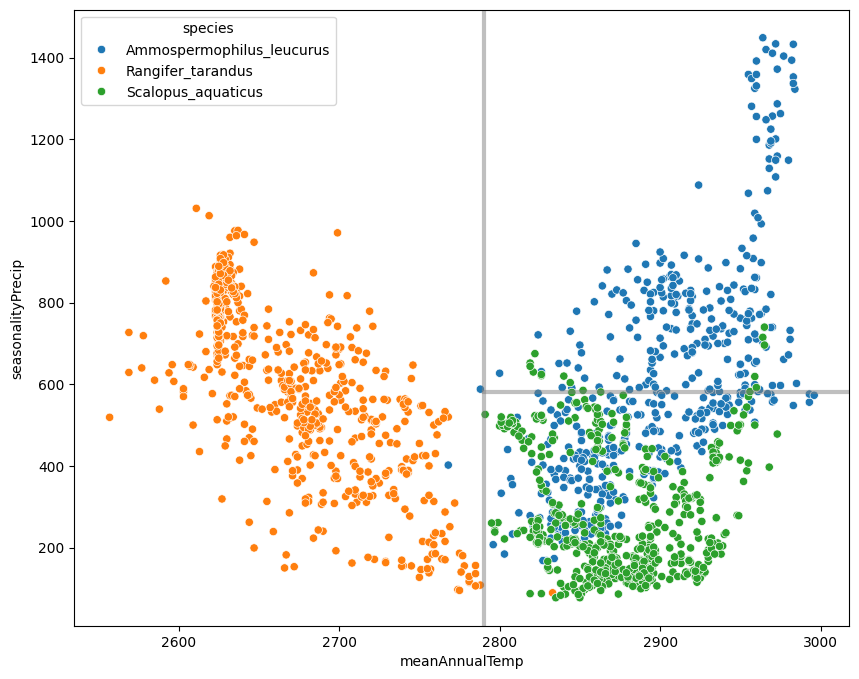

In [94]:
split_temp = 2790
split_precip = 580


plot_feature_space(data_subset, covs_subset)
ax = plt.gca()

xlim, ylim = ax.get_xlim(), ax.get_ylim()

ax.axvline(split_temp, color='gray', linewidth=3, alpha=0.5)
ax.axhline(split_precip,
           color='gray',
           linewidth=3,
           alpha=0.5,
           xmin=(split_temp-xlim[0])/(xlim[1]-xlim[0]))

It's not perfect, but we could use that as a start to assign split regions to species.

Above, we have defined the splits manually – in a sense, it's a mechanistic model. However, since we
have observations, we can also create them algorithmically.

🖌️ Scikit-learn has a decision tree classifier built-in. Look it up and implement it below on our
subset data (`X_subset` and `y_subset`).

In [95]:
from sklearn.tree import DecisionTreeClassifier

# create decision tree object
decision_tree = DecisionTreeClassifier(max_depth=2)

# fit to data
decision_tree.fit(X_subset, y_subset)

DecisionTreeClassifier(max_depth=2)

Decision trees are easily interpretable as it is possible to understand the reason behind a model prediction.

You can visualise the whole decision tree.

[Text(0.5, 0.8333333333333334, 'meanAnnualTemp <= 2789.5\nsamples = 1812\nvalue = [502.0, 738.0, 572.0]\nclass = Rangifer_tarandus'),
 Text(0.25, 0.5, 'meanAnnualTemp <= 2786.5\n738\n[2, 736, 0]\nRangifer_tarandus'),
 Text(0.375, 0.6666666666666667, 'True  '),
 Text(0.125, 0.16666666666666666, '736\n[1, 735, 0]\nRangifer_tarandus'),
 Text(0.375, 0.16666666666666666, '2\n[1, 1, 0]\nAmmospermophilus_leucurus'),
 Text(0.75, 0.5, 'seasonalityPrecip <= 328.5\n1074\n[500, 2, 572]\nScalopus_aquaticus'),
 Text(0.625, 0.6666666666666667, '  False'),
 Text(0.625, 0.16666666666666666, '471\n[64, 2, 405]\nScalopus_aquaticus'),
 Text(0.875, 0.16666666666666666, '603\n[436, 0, 167]\nAmmospermophilus_leucurus')]

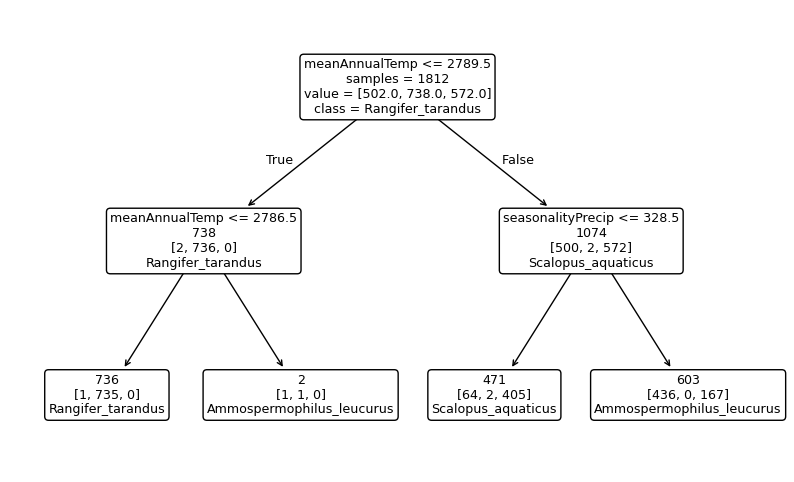

In [96]:
from sklearn.tree import plot_tree

# create a new figure
_, ax = plt.subplots(figsize=(10, 6))

# visualize the trained decision trees
plot_tree(
    decision_tree,
    feature_names=covs_subset,
    class_names=decision_tree.classes_,
    impurity=False,
    label="root",
    rounded=True,
    ax=ax
)

Let's plot the decision boundaries in the scatter plot, too:

<Axes: xlabel='meanAnnualTemp', ylabel='seasonalityPrecip'>

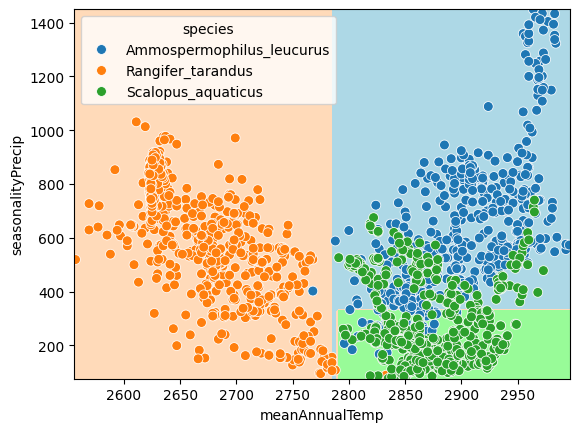

In [97]:
cmap_light = ListedColormap(["lightblue", "peachpuff", "palegreen"])


plot_decision_boundary(decision_tree, X_subset, cmap=cmap_light)
sns.scatterplot(data_subset, x='meanAnnualTemp', y='seasonalityPrecip', hue='species', s=50)


🖌️ Repeat the experiment above but increase the maximum depth beyond 2. Watch what happens. What
can you say about the expected prediction performance of a decision tree under various depth levels?


_Solution_

The higher the depth, the more recursive partitionings (splits) a decision tree can perform.

The optimal depth probably depends on the complexity (separability) of the data: if it's a linearly
separable problem, a low number of splits might suffice; in other cases, more splits with smaller
regions may be necessary.

However, allowing for too many splits might become counterproductive, as decision trees suffer from
problems like noisy labels similarly to $k$-Nearest Neighbour. Moreover, not all small partitionings
make sense; overdo it and the model will overfit.

### 4.4 Random Forest

Decision trees can be quite powerful, but as you have seen above, they can easily overfit if their
depth is too large. This also makes them very susceptible to noise in the data, similar to
$k$-Nearest Neighbour.

Remember random forests from the lecture?

🖌️ Read up about Random Forest and explain in your own words how it works and why it might
outperform a decision tree.

_Solution_

Random Forests are **ensemble** models, that is, it is a combination of multiple models whose
prediction gets averaged.

In this case, we are using multiple decision trees. In a Random Forest specifically, each decision
tree only gets to see a subset of the training data:
* A subset of _data points_,
* and a subset of _features_.

This means that each decision tree is what is called a _weak learner_. However, together (_i.e._,
via majority voting), they can provide really strong prediction power.

This can work better than a single decision tree because noisy data points, outliers and errors can
only affect a (small) subset of decision trees, thanks to the randomisation aspect. The majority
consensus remains unaffected.

🖌️ Read the Scikit-learn
[documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
about Random Forest. Create a new model and fit it to the subset training data below.

In [98]:
from sklearn.ensemble import RandomForestClassifier


random_forest = RandomForestClassifier(n_estimators=10)

random_forest.fit(X_subset, y_subset)

RandomForestClassifier(n_estimators=10)

Here's the decision boundary of that model:

<Axes: xlabel='meanAnnualTemp', ylabel='seasonalityPrecip'>

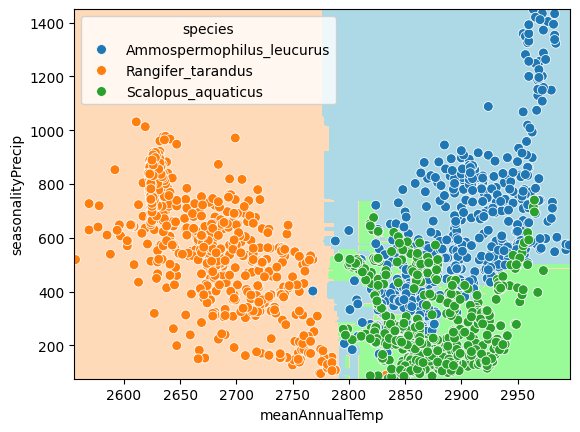

In [99]:
plot_decision_boundary(random_forest,
                       X_subset,
                       cmap=cmap_light,
                       grid_resolution=300)
sns.scatterplot(data_subset, x='meanAnnualTemp', y='seasonalityPrecip', hue='species', s=50)

We have now had a look at various supervised classifiers and how they behave under some data
regimes. But how well do they actually perform? And: how can we tune them (their hyperparameters) so
that they perform optimally? Let's take a look at these questions in the next section!

### 4.5 Data splitting

Identifying how well our model performs has something to do with whether it makes predictions that
are correct. The more (and more diverse) data points we evaluate this for, the more statistically
significant our estimate becomes.

However, we also cannot just reuse the data points we used to train a model to assess how well it
performs – since the model has already seen these points, the task would be too trivial. $k$-Nearest
Neighbour, for example, would achieve a perfect score (can you see why?).


Instead, we have to use points for evaluation that the model has never seen before. We can do that
by partitioning our original dataset into **splits** and using one part for training and another for
testing.

Scikit-learn offers a function to do that,
[train_test_split](https://scikit-learn.org/1.5/modules/generated/sklearn.model_selection.train_test_split.html).

🖌️ Look up the function documentation and implement it on our data subset by completing the code
cell below.

💡 As is normal, we need to indicate how much of the dataset we assign to the training and how much
to the test set. Let us go for a split of 60% for training and 40% for testing.

💡 Make sure to also provide a random integer to variable `random_state`. Look up in the
documentation what this does (or ask the tutors).

In [188]:
from sklearn.model_selection import train_test_split

data_subset_train, data_subset_test = train_test_split(data_subset,
                                                       test_size=0.4,
                                                       random_state=42,
                                                       stratify=data_subset['species'])

Let's visualise them again in feature space:

Output(outputs=({'output_type': 'display_data', 'data': {'text/plain': "Dropdown(description='x Axis:', option…

<Figure size 640x480 with 0 Axes>

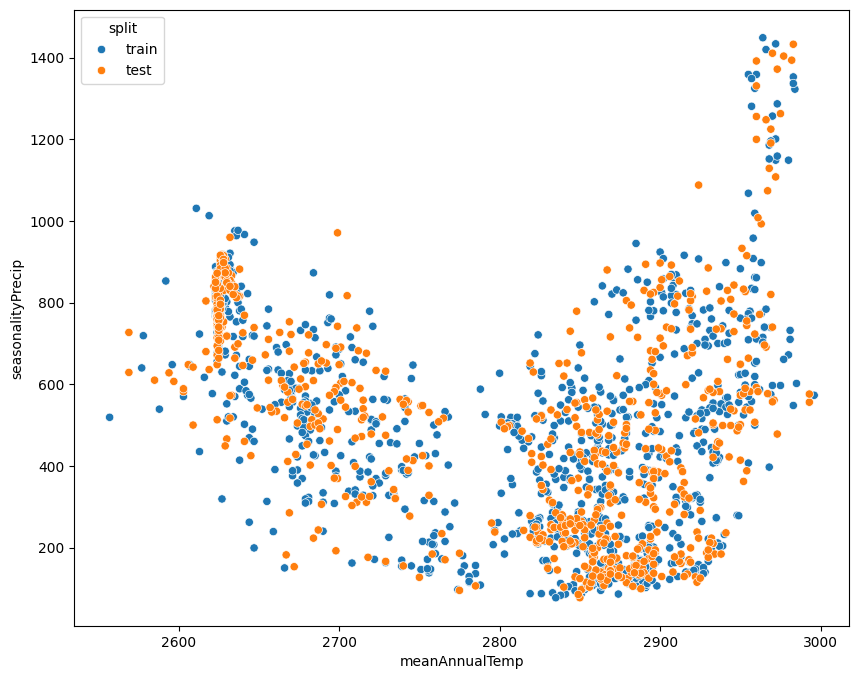

In [189]:
splits = pd.concat([data_subset_train, data_subset_test])
splits['split'] = len(data_subset_train)*['train'] + len(data_subset_test)*['test']

plot_feature_space(splits, covs_subset, colour_by=['split'])

And in geographic space:

In [191]:
fig = px.scatter_mapbox(splits,
                        lat='lat',
                        lon='lon',
                        title='Observations',
                        hover_name='species',
                        color='split',
                        height=600,
                        width=800,
                        zoom=2)
fig.update_layout(mapbox_style='open-street-map')
fig.show()

Finally, let's also plot a histogram of how many data points we have in each split per species:

<Axes: xlabel='Count', ylabel='species'>

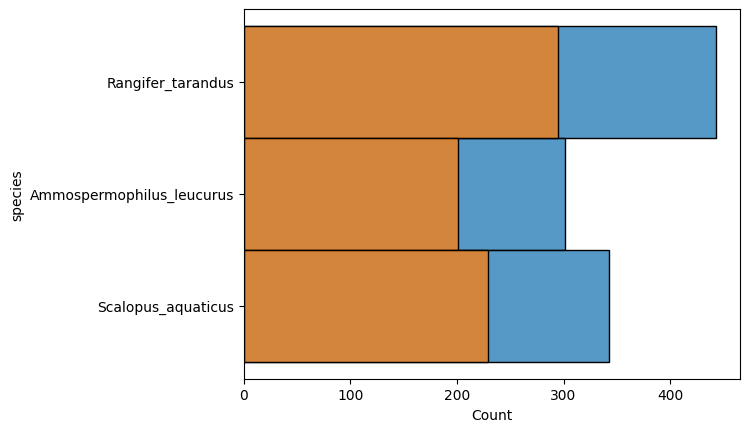

In [192]:
sns.histplot(data_subset_train, y='species')
sns.histplot(data_subset_test, y='species')

You may or may not see some problems with this split.

🖌️ Can you indicate scenarios where such a splitting procedure could result in problems?

_Solution_

Random splits can become problematic whenever we have _biases_ in the data, such as:
* Class imbalances (we might lose a species in one of the sets if we don't stratify by it)
* Uneven spatial distribution of data points (above, most of the test points are in the U.S. and
  Canada is underrepresented)
* Spatial or temporal autocorrelation: this is a big problem especially in ecology. If our training
  and test points are really close together in space and/or time, they are likely to also have
  similar features (autocorrelation). Although the model will still never have seen the actual test
  point in question, it will have seen a training point that is too similar to it, inflating the
  test result scores.
* Uneen spatial distribution of features: in addition to the labels, also covariates may be unevenly
  represented across splits. A model trained only on the deserts of Arizona might not know what to
  do with the boreal forests of Northern Canada.
* (Partial) data overlap: we mentioned autocorrelation above. Some models might take features into
  account that are spatial in themselves, such as patches of satellite imagery. If training and test
  points are too close together, their values will effectively overlap by a bit, causing
  _information leakage_ across splits. Or, if you have drone images from a consecutive flight path
  and split them randomly, they might overlap as well.


All of these can result in overly optimistic test set performance figures. You would be surprised
how much research and how many scientific papers are affected by this problem!

💡 In reality, we can almost never ensure zero-leakage across splits while also catering for all the
variation in the data. We must find a compromise – tip: if you run into this issue (and you likely
will), just make sure to choose a sensible compromise and document and justify it well.

From the lecture, you should remember that we actually need **three** splits: training, validation,
and test.

Recap as to why this is the case:
The training-evaluation phase of an ML model pipeline consists in a loop:
1. Choose and configure a model (set its _hyperparameters_, by hand).
2. Train the model (fit; set model's learnable parameters) - this is done with the _training
   set_.
3. Measure the model's prediction performance, both on the _training and validation sets_.
4. Assess performance: if satisfactory, move on to step 5. If not, repeat from step 1 by adjusting
   hyperparameters. To do so, check whether the model is _underfitting_ (low accuracy on both sets)
   or _overfitting_ (high training, low validation set performance).
5. With the final model (no more changes to hyperparameters), predict on the _test set_ to measure
   ultimate performance of the whole pipeline.

We could use crossvalidation to create and test validation sets, but our dataset is big enough that
we can also just define a separate validation set.

🖌️ Apply the `train_test_split` function from above once more on the training set to further split
it into 80% training and 20% validation sets.

In [193]:
data_subset_train, data_subset_val = train_test_split(data_subset_train,
                                                      test_size=0.2,
                                                      random_state=42,
                                                      stratify=data_subset_train['species'])

Now, we can train a model on the training set and predict species labels on the validation set.

🖌️ Train a random forest on the training set and predict labels on the validation set below.

In [194]:
# create model
random_forest = RandomForestClassifier(n_estimators=10)

# fit to training data
random_forest.fit(data_subset_train[covs_subset], data_subset_train['species'])

# predict labels on validation set
y_hat_val = random_forest.predict(data_subset_val[covs_subset])

### 4.6 Accuracy Metrics

Now that we have models and data splits, all we need is a measure of how good a prediction is. We can do so with accuracy metrics.

For classification, the simplest is overall accuracy: the percentage of correctly predicted divided
by the total number of data points.

In [195]:
correct = y_hat_val == data_subset_val['species']

correct

915      True
5880     True
5883     True
5975     True
3108     True
        ...  
2530     True
691     False
6318     True
5767     True
5900     True
Name: species, Length: 218, dtype: bool

In [196]:
overall_accuracy = correct.sum() / len(correct)

print(f'Overall accuracy: {overall_accuracy:.2%}')

Overall accuracy: 89.45%


Scikit-learn also has an overall accuracy calculation method built-in:

In [197]:
from sklearn import metrics

overall_accuracy_sklearn = metrics.accuracy_score(data_subset_val['species'], y_hat_val)

print(f'Overall accuracy (scikit-learn): {overall_accuracy_sklearn:.2%}')

Overall accuracy (scikit-learn): 89.45%


Overall accuracy is good for a quick overview, but it can be severely misleading, especially if
there is class imbalance or if the data exhibits other biases.

Scikit-learn offers a number of other validation metrics: see [here](https://scikit-learn.org/1.5/modules/model_evaluation.html#classification-metrics).

For the rest of this exercise, we'll continue with overall accuracy.

### 4.7 Grid search

From the parts above you are probably guessing that different ML models yield different performance
scores. Moreover, each model can be configured with different hyperparameters; maybe there is an
optimal combination of those? Wouldn't it make sense if we could try a few hyperparameter
combinations from the start?

Doing this is called **grid search**: we test all combinations of hyperparameter values on a grid
and note down the accuracy the model yields for each. The best one is the model we'll retain.

In the following, we will try this idea using a random forest and two of its hyperparameters:
* Number of decision trees
* Maximum tree depth

First, let's define a few values that make sense for both of these parameters.

🖌️ Add a few values (_e.g._, 5-6 for each hyperparameter) into the lists below that you think make
sense.

In [124]:
NUM_TREES = [1, 5, 10, 50, 100, 200]
MAX_DEPTH = [3, 5, 10, 15, 20, 30]

Next, let's implement our grid search. Basically:
```
for n_tree in NUM_TREES:
    for max_depth in MAX_DEPTH:
        1. train model on training set
        2. predict labels for training set, calculate accuracy
        3. predict labels for validation set, calculate accuracy
Choose optimal combination
```

🖌️ Implement this routine by completing the code cell below.

In [125]:
import time


# arrays to store obtained training and validation accuracies
scores_train = np.zeros((len(NUM_TREES), len(MAX_DEPTH)))
scores_val = np.copy(scores_train)

# same for running time
runtime = np.copy(scores_train)

# implement grid search
for idx_a, n_trees in enumerate(NUM_TREES):
    for idx_b, max_depth in enumerate(MAX_DEPTH):

        # start timer
        tic = time.time()

        # create model
        random_forest = RandomForestClassifier(n_estimators=n_trees,
                                               max_depth=max_depth)
        
        # fit on training data
        random_forest.fit(data_subset_train[covs_subset], data_subset_train['species'])

        # predict training set and calculate accuracy
        y_hat_train = random_forest.predict(data_subset_train[covs_subset])
        score_train = metrics.accuracy_score(data_subset_train['species'], y_hat_train)

        # predict validation set and calculate accuracy
        y_hat_val = random_forest.predict(data_subset_val[covs_subset])
        score_val = metrics.accuracy_score(data_subset_val['species'], y_hat_val)

        # stop timer
        toc = time.time() - tic

        # store values
        scores_train[idx_a,idx_b] = score_train
        scores_val[idx_a,idx_b] = score_val
        runtime[idx_a,idx_b] = toc

Let's visualise the result:

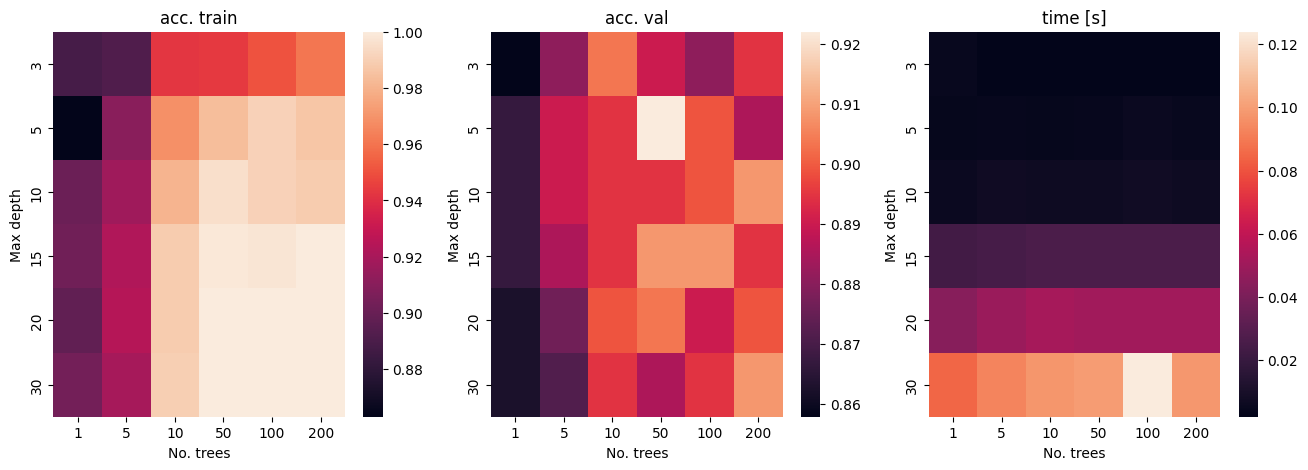

In [126]:
plt.figure(figsize=(16,5))
for idx, (name, mat) in enumerate((('acc. train', scores_train),
                                   ('acc. val', scores_val),
                                   ('time [s]', runtime))):

    plt.subplot(1,3,idx+1)
    sns.heatmap(mat, xticklabels=NUM_TREES, yticklabels=MAX_DEPTH)
    plt.xlabel('No. trees')
    plt.ylabel('Max depth')
    plt.title(name)

Do you notice a pattern? You may want to think back about the lecture and why we are doing these
splits in the first place.

🖌️ Re-run all the code cells from Section 4.5 on, but use a different value for `random_state` in
the two `train_test_split` cells. What happens? Can you explain why?

_Solution_

A random state (also known as seed) primes the random number generator in a way that is
reproducible. In other words, it will always produce the same sequence of random numbers if
repeatedly executed, as long as the seed value stays the same.

This is important to be able to fully reproduce any results you have obtained. Lots of aspects of ML
are based on probability theory, which involves one form or another of calculating random numbers.

Of course, if we change the seed, we get different random numbers – and above, different split
assignments (and therefore slightly different accuracy scores). As long as the training, validation,
and test sets are large enough, this variation is all within expectation.

💡 As good practice, always make sure to set a random state at the beginning of your project.

🖌️ Let's pick a combination of hyperparameters you like best:

In [127]:
NUM_TREES_FINAL = 50
MAX_DEPTH_FINAL = 20

Now, we keep this set of hyperparameters fixed. All that we have got left to do is to train the
model with them and see how well it scores on the test set.

🖌️ Create a random forest model with your final hyperparameters below, fit it on the training data
and predict on the _test_ data.

In [128]:
random_forest_final = RandomForestClassifier(n_estimators=NUM_TREES_FINAL,
                                             max_depth=MAX_DEPTH_FINAL)

random_forest_final.fit(data_subset_train[covs_subset], data_subset_train['species'])

# predict on test set
y_hat_test = random_forest_final.predict(data_subset_test[covs_subset])

# calculate accuracy
accuracy_test = metrics.accuracy_score(data_subset_test['species'], y_hat_test)

print(f'Final model performance on test set: {accuracy_test:.2%}.')

Final model performance on test set: 88.97%.


### 4.8 The Curse of Dimensionality

From everything you have seen above, it makes sense that our features must show some correlation
with our modelling target, for an ML model to be able to do its job.

Actually, if the features have nothing to do with our target, they can even be _harmful_ for the
model's learning process, because they can give erroneous signals.

Also related to this is the fact that we can't just keep on adding more and more features, no matter
how meaningful they are, unless we also increase the number of training points. This phenomenon is
known as the **curse of dimensionality**.

Let us see it in action. Below, we take the same random data subset from above, but add increasing
numbers of _random_ extra features. Watch what happens with accuracy scores.


🖌️ Complete the code cell below by specifying a supervised ML model of your choice to try this out.

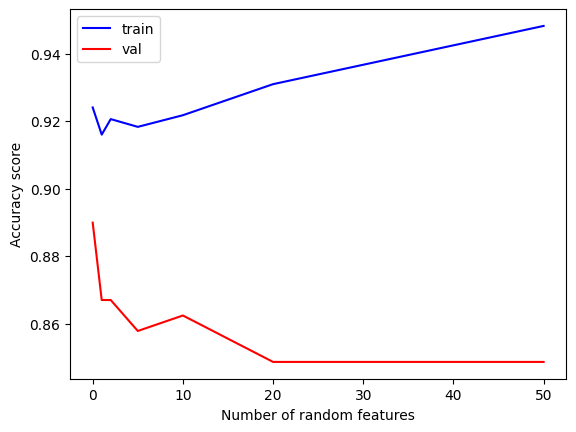

In [174]:
import copy


NUM_RANDOM_FEATURES = [0, 1, 2, 5, 10, 20, 50]

scores_train, scores_val = [], []

for num_random in NUM_RANDOM_FEATURES:
    data_subset_train = data_subset_train.copy()
    data_subset_val = data_subset_val.copy()
    covs_subset_copy = copy.deepcopy(covs_subset)

    # generate random features and append to data frame
    for idx in range(num_random):
        feat_name = f'random_{idx}'
        covs_subset_copy.append(feat_name)
        data_subset_train[feat_name] = np.random.randn(len(data_subset_train))
        data_subset_val[feat_name] = np.random.randn(len(data_subset_val))
    
    # fit model
    # example solution: random forest
    model = RandomForestClassifier(n_estimators=100, max_depth=5)
    model.fit(data_subset_train[covs_subset_copy], data_subset_train['species'])
    
    # predict and calculate accuracy scores
    oa_train = model.score(data_subset_train[covs_subset_copy], data_subset_train['species'])
    oa_val = model.score(data_subset_val[covs_subset_copy], data_subset_val['species'])
    scores_train.append(oa_train)
    scores_val.append(oa_val)


# plot scores
plt.plot(NUM_RANDOM_FEATURES, scores_train, 'b-', label='train')
plt.plot(NUM_RANDOM_FEATURES, scores_val, 'r-', label='val')
plt.legend()
plt.xlabel('Number of random features')
plt.ylabel('Accuracy score')
plt.show()

Depending on the complexity (learning capacity) of your model, you should be able to see some of the
following phenomena:
* Increasing training set score, decreasing validation set score
* Stabilising training set score, decreasing validation set score
* Both going down

Whatever you do, the validation set score will likely go down: the model overfits to the noisy
features!

**Bonus: counteract the curse of dimensionality**

As explained, the curse of dimensionality can also happen if we add meaningful features but have too
many of them. What can we do in this case?

🖌️ In the code cell below, apply a PCA with a sensible number of principal components to the
features prior to training a model on it. Identify the number of features with a scree plot (see
above). Add your model again to the code block below.

Final score with 50 random features + PCA: train: 92.41%, val: 87.16%.


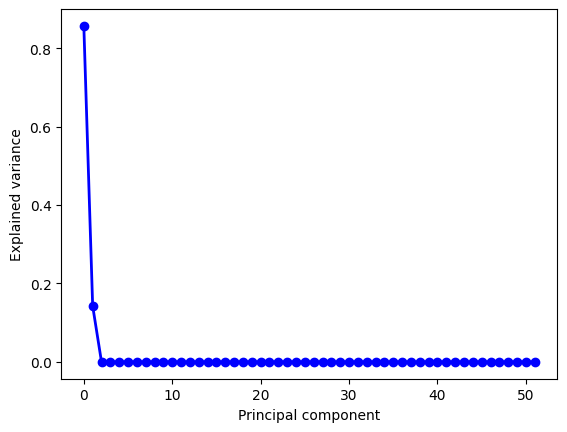

In [178]:
# let's fix the number of random features for now
NUM_RANDOM_FEATURES = 50

# generate random features and append to data frame
data_subset_train = data_subset_train.copy()
data_subset_val = data_subset_val.copy()
covs_subset_copy = copy.deepcopy(covs_subset)

for idx in range(num_random):
    feat_name = f'random_{idx}'
    covs_subset_copy.append(feat_name)
    data_subset_train[feat_name] = np.random.randn(len(data_subset_train))
    data_subset_val[feat_name] = np.random.randn(len(data_subset_val))


# apply PCA on training set first
pca = PCA()
pca.fit(data_subset_train[covs_subset_copy])

# scree plot
plt.plot(range(len(covs_subset_copy)), pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.xlabel('Principal component')
plt.ylabel('Explained variance')

# transform data and select meaningful PCs – can you guess why it's always two of them here?
pc_train = pca.transform(data_subset_train[covs_subset_copy])[:,:2]
pc_val = pca.transform(data_subset_val[covs_subset_copy])[:,:2]

# fit model
# example solution: random forest
model = RandomForestClassifier(n_estimators=100, max_depth=5)
model.fit(pc_train, data_subset_train['species'])

# predict and calculate accuracy scores
oa_train = model.score(pc_train, data_subset_train['species'])
oa_val = model.score(pc_val, data_subset_val['species'])

print(f'Final score with {NUM_RANDOM_FEATURES} random features + PCA: train: {oa_train:.2%}, val: {oa_val:.2%}.')

---

### 5. Exercise: putting it all together

We've now seen a "complete" ML pipeline:
1. Data loading
2. Data cleaning (in this case, we only had to remove NaN values)
3. Exploration and visualisation (scatter plots, histograms; clustering, dimensionality reduction)
4. Data splitting (training, validation, and test sets)
5. Model selection: grid search of hyperparameters using training and validation sets
6. Model prediction on test set

We could now go ahead and start to interpret these results, maybe look for patterns, _etc._
That step is called _inference_, and we will see a bit of that towards the end of the module.

Before that, however, let's see how well our model works on _all_ the data! Remember that we've only
used a subset of three species and two covariates above.

🖌️ Train a supervised species prediction model for the full dataset, starting from the `data`
DataFrame. You can choose _(a.)_ which [scikit-learn ML
model](https://scikit-learn.org/1.6/supervised_learning.html) you want to use and _(b.)_ which two
hyperparameters you want to apply grid search for. Ultimately, you should end up with a
`final_model`.

In [183]:
# example: using gradient boosting
from sklearn.ensemble import GradientBoostingClassifier

# split into train/val/test sets
data_train, data_test = train_test_split(data, test_size=0.4, stratify=data['species'])
data_train, data_val = train_test_split(data_train, test_size=0.2, stratify=data_train['species'])


# hyperparameters: learning rate, n_estimators
LEARNING_RATES = np.linspace(1e-4, 1, num=5)
NUM_TREES = [5, 25, 50, 100, 200, 500]

# grid search
scores_train = np.zeros((len(NUM_TREES), len(LEARNING_RATES)))
scores_val = np.copy(scores_train)

# same for running time
runtime = np.copy(scores_train)

# implement grid search
for idx_a, n_trees in enumerate(NUM_TREES):
    for idx_b, learning_rate in enumerate(LEARNING_RATES):

        # start timer
        tic = time.time()

        # create model
        model = GradientBoostingClassifier(n_estimators=n_trees,
                                                   learning_rate=learning_rate)
        
        # fit on training data
        model.fit(data_subset_train[covs_subset], data_subset_train['species'])

        # predict training set and calculate accuracy
        y_hat_train = model.predict(data_subset_train[covs_subset])
        score_train = metrics.accuracy_score(data_subset_train['species'], y_hat_train)

        # predict validation set and calculate accuracy
        y_hat_val = model.predict(data_subset_val[covs_subset])
        score_val = metrics.accuracy_score(data_subset_val['species'], y_hat_val)

        # stop timer
        toc = time.time() - tic

        # store values
        scores_train[idx_a,idx_b] = score_train
        scores_val[idx_a,idx_b] = score_val
        runtime[idx_a,idx_b] = toc

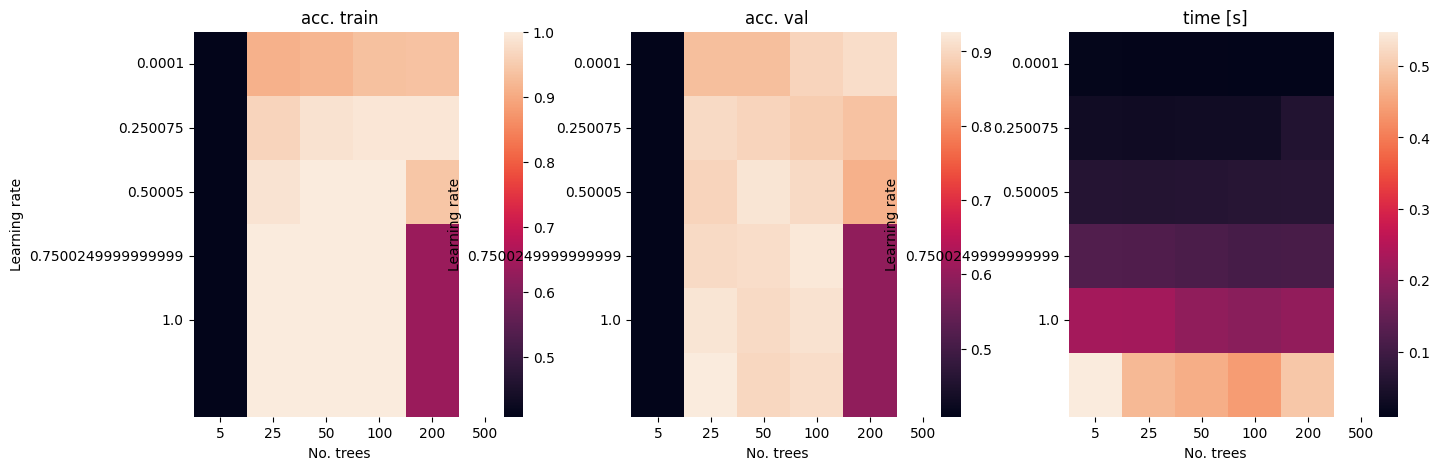

In [184]:
plt.figure(figsize=(16,5))
for idx, (name, mat) in enumerate((('acc. train', scores_train),
                                   ('acc. val', scores_val),
                                   ('time [s]', runtime))):

    plt.subplot(1,3,idx+1)
    sns.heatmap(mat, xticklabels=NUM_TREES, yticklabels=LEARNING_RATES)
    plt.xlabel('No. trees')
    plt.ylabel('Learning rate')
    plt.title(name)

In [185]:
# select hyperparameters and train final model
final_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.25)

final_model.fit(data_train[cov_cols], data_train['species'])

GradientBoostingClassifier(learning_rate=0.25)

Let's see how well your model performs on the test set:

In [186]:
# predict on test set
y_hat_test = final_model.predict(data_test[cov_cols])

# calculate accuracy
accuracy_test = metrics.accuracy_score(data_test['species'], y_hat_test)

print(f'Final model performance on entire test set: {accuracy_test:.2%}.')

Final model performance on entire test set: 59.94%.


Are you happy with your result?

If you are surprised that the performance is now a lot worse, let's remind ourselves why overall
accuracy is a flawed metric.

In more detail, let's calculate accuracy scores for each species separately, and plot them against
the number of training points accordingly:

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'Rangifer_tarandus'),
  Text(1, 0, 'Microtus_pennsylvanicus'),
  Text(2, 0, 'Marmota_flaviventris'),
  Text(3, 0, 'Scalopus_aquaticus'),
  Text(4, 0, 'Ammospermophilus_leucurus'),
  Text(5, 0, 'Lasiurus_cinereus'),
  Text(6, 0, 'Dipodomys_ordii'),
  Text(7, 0, 'Canis_lupus'),
  Text(8, 0, 'Clethrionomys_gapperi'),
  Text(9, 0, 'Tamiasciurus_douglasii')])

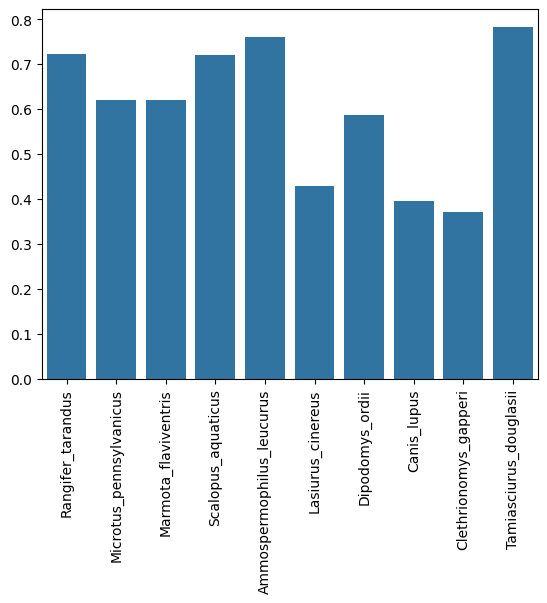

In [187]:
accuracy_scores = {}

for species in data_train['species'].unique():
    valid = data_test['species'] == species
    score = metrics.accuracy_score(data_test['species'][valid], y_hat_test[valid])
    accuracy_scores[species] = score

sns.barplot(accuracy_scores)
plt.xticks(rotation=90)

You might find that your model performs really well for some, but really poorly for other species.

If you go back to the scatter plots of covariate values, as well as the unsupervised learning
outputs we have taken a look at ($k$-means, t-SNE, UMAP), you might find the answer why some species
are predicted better than others.

🖌️ What could have influenced prediction accuracy? Write down a few hypotheses.

_Solution_

By default, performance depends on how separable the data is by the model. This has to do with
multiple factors:
* Adequacy of features (covariates): there has to be at least a correlation between features and
  observed variable (label class), otherwise nothing can tell them apart.
* Number of data points and number of training features: we need "enough" training examples to be
  able to tell classes apart. This required number usually rises with the number of features.
* Model capacity _vs._ data complexity: for example, a linear model can never properly separate
  classes where feature separation is non-linear.
* Sizes of training/validation/test set: if they are too small, we risk not exposing the model to
  sufficient variation for parameter fitting (training), choosing inappropriate hyperparameters
  (validation), or having untrustworthy final performance results (testing).
* Distribution of training/validation/test data: we can't just sample from one location in feature
  space alone, but need to make sure that all _sensible_ combinations of features are represented in
  all three splits. This is especially hard to achieve in ecology: for example, think about how easy
  it would be to train above model with a species that only occurs in Hawaii.
* Class imbalance: another huge challenge (and problem) is if label classes are unevenly represented
  in their numbers. Many models will "latch on" the most frequently occurring label classes and
  "gloss over" the rare ones. This is especially a problem with deep learning.

---

## 6. Regression

Similarly to classification, we can also do regression – that is, prediction of a variable with some
sort of ordering.

Regression really only makes sense if the scale our variable is:
* Ordinal (although we could use some form of classification here, too): _e.g._, IUCN threat status
* Interval: _e.g._, duration of growing season of a tree
* Ratio: _e.g._, biomass of a tree


Like classification, regression models belong to the family of supervised learning algorithms.

Let us first create a toy dataset for a regression task:

<Axes: >

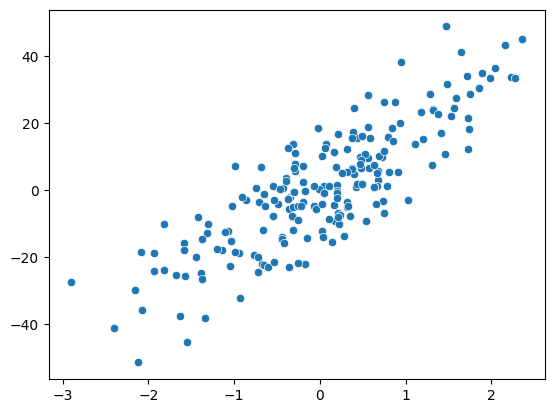

In [138]:
# import make_regression function from scikit-learn datasets module
from sklearn.datasets import make_regression

# generate a random dataset for regression with some noise and 200 points
X_reg, y_reg = make_regression(n_features=1, noise=10, n_samples=200)

# use seaborn to generate a scatterplot
sns.scatterplot(x=X_reg.flatten(), y=y_reg)

### 6.1 Linear regression

A linear regression model assumes that there is a **linear** relation between the features and the
target variable:

$$ {\bf y} = a {\bf x} + b $$

The parameters $a$ (slope) and $b$ (bias) that best "fit" the data points can be found
algorithmically.

How good a model fits the data is determined by minimizing some **loss** or error.

In the case of the linear model, the loss is measured by the Mean Squared Error (MSE) – you have
seen this in the lecture.

Text(0, 0.5, 'y = Target')

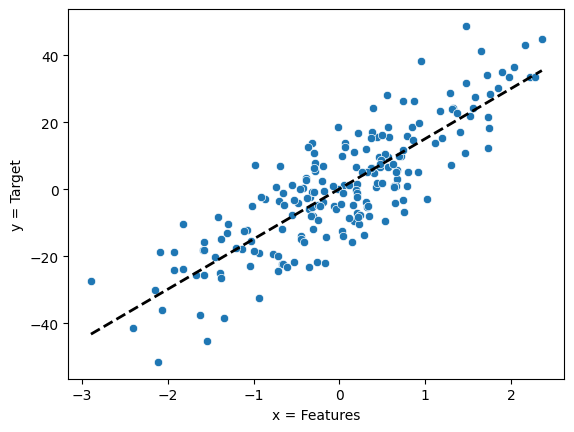

In [139]:
# import the Linear Regression model from scikit-learn
from sklearn.linear_model import LinearRegression

# fit a linear model to the example data
linear_reg_1 = LinearRegression().fit(X_reg, y_reg)

# plot the datapoints. x = features, y = target value
ax = sns.scatterplot(x=X_reg.flatten(), y=y_reg)

x_min = X_reg.min()
x_max = X_reg.max()

# generate a prediction using the linear model on the example data
pred = linear_reg_1.predict([[x_min], [x_max]])

# plot the predicted line
ax.plot([x_min, x_max], pred, color="black", linestyle="--", linewidth=2)

# add labels to axis
ax.set_xlabel("x = Features")
ax.set_ylabel("y = Target")

Once fitted, a prediction for points outside the dataset is computed with the same formula:

$$ {\bf y_{pred}} = a {\bf x_{test}} + b $$

In [140]:
# define a new test point at x = 2
test_point = [2]

In [141]:
# use the linear model to predict its target value
predicted_value = linear_reg_1.predict([test_point])[0]

Text(0, 0.5, 'y = Target')

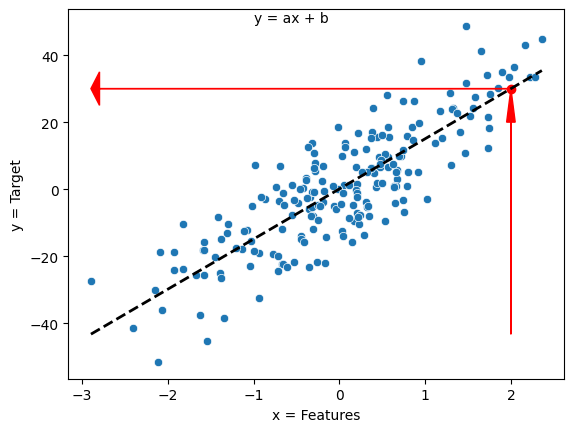

In [143]:
# plot the data points. x = features, y = target value
ax = sns.scatterplot(x=X_reg.flatten(), y=y_reg)

# plot the predicted line
ax.plot([x_min, x_max], pred, color="black", linestyle="--", linewidth=2)

# draw a point at the test point with its predicted value
plt.scatter(test_point, [predicted_value], color="red")

y_min = pred.min()

# draw a vertical arrow from the x-axis at x = test_point to its predicted value
ax.arrow(
    2,
    y_min,
    0,
    predicted_value - y_min,
    color="red",
    head_width=0.1,
    head_length=10,
    length_includes_head=True,
)

# draw a horizontal arrow from the point (x, y) = (test_point, predicted_value) to
# the y-axis at y = predicted_value
ax.arrow(
    test_point[0],
    predicted_value,
    -test_point[0] + x_min,
    0,
    color="red",
    head_width=10,
    head_length=0.1,
    length_includes_head=True,
)

# add the linear formula to the plot
ax.text(-1, 50, "y = ax + b")

# add labels to axis
ax.set_xlabel("x = Features")
ax.set_ylabel("y = Target")

Now, based on what we have seen for classification, we should be able to make the same thought jumps
regarding complexity of the data: we can try to regress a non-linear relationship, and we can even
use similar methods to do so as for classification.

💡 In the next two weeks you'll see that we can cast classification as a regression problem.
Keyword: logistic regression. Let's save this for later. 😉

### 6.2 Nearest Neighbour Regression

If we can calculate distances between points to infer labels (_cf._ $k$-Nearest Neighbour
classifier), we can also use it to infer regression targets.

Let's see this in action with a more complex dataset.

Text(0, 0.5, 'y = Target')

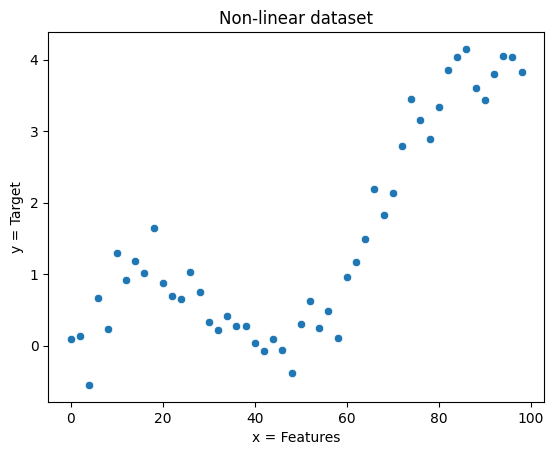

In [146]:
# create another dataset
# here, target_ideal is a non-linear function of x
X_reg_2 = np.arange(0, 100, 2.0)
y_reg_2_ideal = np.sin(X_reg_2 / 10) + (X_reg_2 / 50) ** 2

# add some noise to our target variable target_ideal
y_reg_2 = y_reg_2_ideal + np.random.normal(size=len(y_reg_2_ideal)) * 0.3


# plot scatter points (x = features, y = target)
ax = sns.scatterplot(x=X_reg_2, y=y_reg_2)

# add title
ax.set_title("Non-linear dataset")

# add labels to axis
ax.set_xlabel("x = Features")
ax.set_ylabel("y = Target")

As with classification, linear models are very rigid and will underfit here:

In [147]:
# fit linear model
linear_reg_2 = LinearRegression()
linear_reg_2.fit(X_reg_2.reshape(-1, 1), y_reg_2)

LinearRegression()

<Axes: >

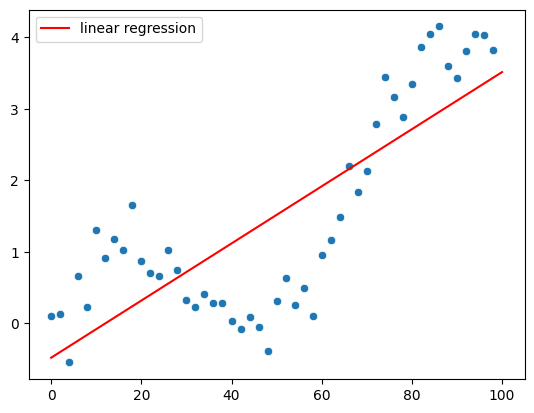

In [148]:
# predict on a range of test points
test_points = np.linspace(0, 100, 1000)
linear_reg_pred_2 = linear_reg_2.predict(test_points.reshape(-1, 1))

# plot dataset
sns.scatterplot(x=X_reg_2, y=y_reg_2)

# plot the fitted linear model
sns.lineplot(x=test_points, y=linear_reg_pred_2, color="red", label="linear regression")

Let's see what Nearest Neighbour regression does:

In [149]:
# import Nearest Neighbour Regression model from scikit-learn
from sklearn.neighbors import KNeighborsRegressor

# fit nearest neighbour model
knn_reg = KNeighborsRegressor(n_neighbors=1)
knn_reg.fit(X_reg_2.reshape(-1, 1), y_reg_2)

KNeighborsRegressor(n_neighbors=1)

<Axes: >

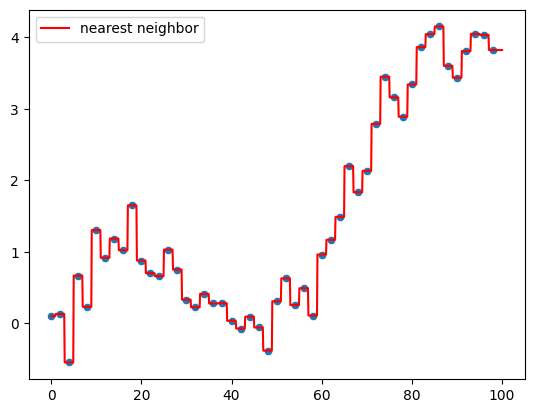

In [150]:
# predict on a range of test points
test_points = np.linspace(0, 100, 1000)
knn_reg_pred_2 = knn_reg.predict(test_points.reshape(-1, 1))

# plot dataset
sns.scatterplot(x=X_reg_2, y=y_reg_2)

# plot fitted nearest neighbor model
sns.lineplot(x=test_points, y=knn_reg_pred_2, color="red", label="nearest neighbor")

That works better.

However, nearest neighbour regression suffers from the same problems as nearest neighbour
classification:
    
* Sensitive to noise
* Heavy on computation and memory

### 6.3 Random Forest Regression

You guessed it – Random Forest can be adapted to perform regression, too!

In [151]:
# import Nearest Neighbor Regression model from scikit-learn
from sklearn.ensemble import RandomForestRegressor


# fit random forest regression model
rf_reg = RandomForestRegressor()
rf_reg.fit(X_reg_2.reshape(-1, 1), y_reg_2)

RandomForestRegressor()

<Axes: >

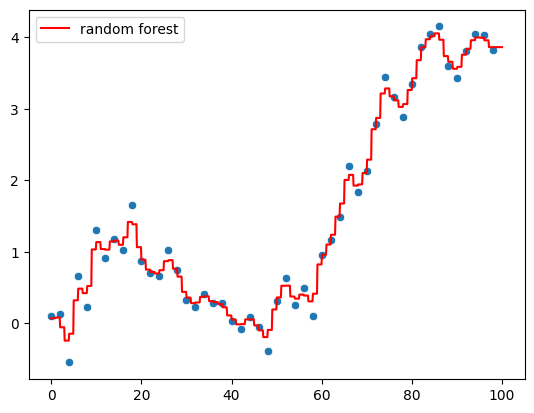

In [152]:
# predict on a range of test points
test_points = np.linspace(0, 100, 1000)
rf_reg_pred_2 = rf_reg.predict(test_points.reshape(-1, 1))

# plot the fitted linear model and random forest
sns.scatterplot(x=X_reg_2, y=y_reg_2)

sns.lineplot(x=test_points, y=rf_reg_pred_2, color="red", label="random forest")

### 6.4 Evaluation

It should come as no surprise that _every single step_ from here on for regression works the same as
with classification, including definition of performance metric, train/val/test splits,
hyperparameter selection, _etc._.

The key difference is the metrics, in case of regression often identical to the loss functions (more
on that next week).

The first one we can take a look at is the **Mean Absolute Error (MAE)**:

$$ MAE = \frac{1}{n} \sum_{i = 1}^{n} |y_{true} - y_{pred}| $$

Where $|...|$ denotes the absolute function (all values become positive).

The absolute error can easily be visualised...

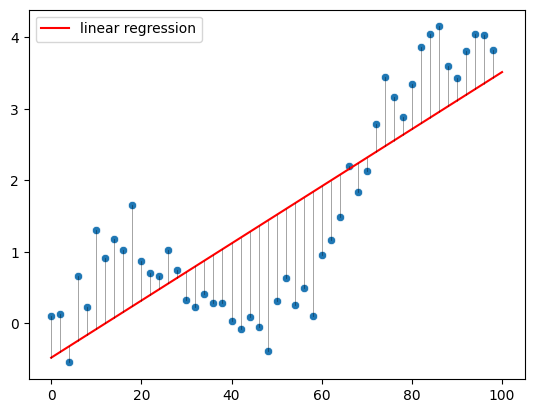

In [153]:
# plot training dataset
ax = sns.scatterplot(x=X_reg_2, y=y_reg_2)

# plot fitted line
sns.lineplot(x=test_points, y=linear_reg_pred_2, color="red", label="linear regression")

# use linear model to predict on original dataset
y_reg_2_linear_pred = linear_reg_2.predict(X_reg_2.reshape(-1, 1))

# plot absolute errors
for x, y_true, y_pred in zip(X_reg_2, y_reg_2, y_reg_2_linear_pred):
    ax.plot([x, x], [y_true, y_pred], alpha=0.5, color="black", linewidth=0.5)

...and calculated:

In [154]:
# compute the array of differences in prediction and true value
error = y_reg_2 - y_reg_2_linear_pred

# compute the absolute of each error
absolute_error = np.abs(error)

# compute the mean
MAE = absolute_error.mean()

print(f"MAE of the linear model on the training dataset: {MAE}")

MAE of the linear model on training dataset: 0.7764524230937928


Similarly, we can calculate the **Mean Squared Error (MSE)**:

In [155]:
# compute the square of each error
squared_error = error ** 2

# compute the mean
MSE = squared_error.mean()

print(f"MSE of the linear model on the training dataset: {MSE}")

# with scikit-learn
from sklearn.metrics import mean_squared_error

# use scikit-learn function to compute MSE
MSE = mean_squared_error(y_true=y_reg_2, y_pred=y_reg_2_linear_pred)

print(f"MSE of the linear model on the training dataset (with Scikit-learn): {MSE}")

MSE of the linear model on the training dataset: 0.786607786435588
MSE of the linear model on the training dataset (with Scikit-learn): 0.786607786435588


[Here](https://scikit-learn.org/1.5/api/sklearn.metrics.html#regression-metrics) are all the
implementations of Scikit-learn.

Let's again split the dataset to compare regression models accordingly. We'll only use two splits
for demonstration purposes; as said, all the grid search part would remain the same if implemented
properly.

In [156]:
# split features and target into train and test. Test is 30% of all data.
X_reg_2_train, X_reg_2_test, y_reg_2_train, y_reg_2_test = train_test_split(
    X_reg_2, y_reg_2, test_size=0.3
)

# iterate over model types
for model in [
    LinearRegression(),
    KNeighborsRegressor(n_neighbors=1),
    RandomForestRegressor(),
]:
    # fit the model to training data
    model.fit(X_reg_2_train.reshape(-1, 1), y_reg_2_train)

    # use fitted model to predict in test data
    y_pred = model.predict(X_reg_2_test.reshape(-1, 1))

    # compute MSE using the predictions and ground truth
    mse = mean_squared_error(y_true=y_reg_2_test, y_pred=y_pred)

    print(f"{str(model):>34} mse = {mse}")

                LinearRegression() mse = 0.7347269148787696
KNeighborsRegressor(n_neighbors=1) mse = 0.1646079957201608
           RandomForestRegressor() mse = 0.09767270628504009


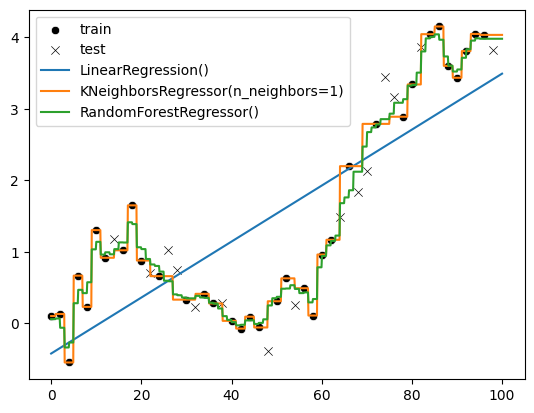

In [157]:
# plot train and test points
sns.scatterplot(
    x=X_reg_2_train,
    y=y_reg_2_train,
    color="black",
    marker="o",
    label="train",
)

sns.scatterplot(
    x=X_reg_2_test,
    y=y_reg_2_test,
    color="black",
    marker="x",
    label="test",
)

# iterate over model types
for model in [
    LinearRegression(),
    KNeighborsRegressor(n_neighbors=1),
    RandomForestRegressor(),
]:
    # fit the model to training data
    model.fit(X_reg_2_train.reshape(-1, 1), y_reg_2_train)

    # generate predictions in range of data points
    test_points = np.linspace(0, 100, 1000)
    y_pred = model.predict(test_points.reshape(-1, 1))

    # plot predicted line
    sns.lineplot(x=test_points, y=y_pred, label=str(model))

And again, just like for classification, we can have more than one feature:

Text(40.400888888888886, 0.5, 'feature 2')

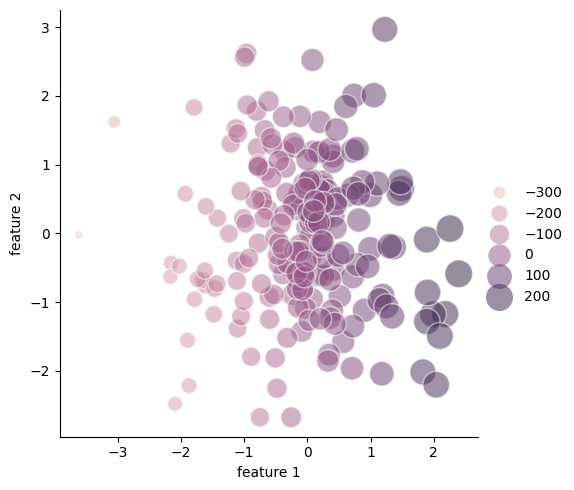

In [158]:
# generate a synthetic dataset for regression with 2 features
X_2D, y_2D = make_regression(
    n_samples=200,
    n_features=2,
    n_targets=1,
)

# visualise with seaborn
# plot points at (x = feature 1, y = feature 2)
# use the target variable to determine point size and colour
grid = sns.relplot(
    x=X_2D[:, 0],
    y=X_2D[:, 1],
    size=y_2D,
    sizes=(40, 400),
    alpha=0.5,
    hue=y_2D,
)

# add axis labels
grid.ax.set_xlabel("feature 1")
grid.ax.set_ylabel("feature 2")

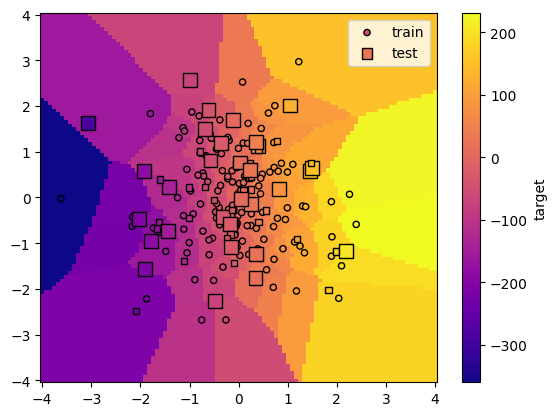

In [159]:
# split dataset into train and test
X_2D_train, X_2D_test, y_2D_train, y_2D_test = train_test_split(
    X_2D,
    y_2D,
    test_size=0.3,
)

# fit a Nearest Neighbor Regression model to training data
knn_reg_2D = KNeighborsRegressor(n_neighbors=1).fit(X_2D_train, y_2D_train)

# create a mesh of points
XX, YY = np.meshgrid(np.linspace(-4, 4, 100), np.linspace(-4, 4, 100))

# predict on each point in mesh
knn_2D_predictions = knn_reg_2D.predict(np.c_[XX.flatten(), YY.flatten()])

# compute the min and max value of predictions
vmin, vmax = knn_2D_predictions.min(), knn_2D_predictions.max()

# select colormap
# see available colormaps at https://matplotlib.org/stable/tutorials/colors/colormaps.html
cmap = "plasma"

# plot
ax = plt.pcolormesh(
    XX,
    YY,
    knn_2D_predictions.reshape(XX.shape),
    vmin=vmin,
    vmax=vmax,
    cmap=cmap,
)

# create a color bar to indicate mapping between columns and target values
cbar = plt.colorbar()

# add label to color bar
cbar.set_label("target")

# plot training data as small round points
plt.scatter(
    X_2D_train[:, 0],
    X_2D_train[:, 1],
    c=y_2D_train,
    s=20,
    edgecolor="black",
    label="train",
    vmin=vmin,
    vmax=vmax,
    cmap=cmap,
)

# compute predictions at test points
y_2D_test_pred = knn_reg_2D.predict(X_2D_test)

# compute prediction absolute error
error = np.abs(y_2D_test - y_2D_test_pred)

# plot test data as large square markers
# color squares using true value of target variable
# use absolute error to determine square size
plt.scatter(
    X_2D_test[:, 0],
    X_2D_test[:, 1],
    s=error,
    c=y_2D_test,
    marker="s",
    edgecolor="black",
    label="test",
    vmin=vmin,
    vmax=vmax,
    cmap=cmap,
    sizes=(20, 100),
)

# add legend to figure
plt.legend()

---

## 7. Conclusion

Congratulations for making it to the end of today's exercise! You have seen many different concepts,
but together, they gave you insights into the basics of machine learning. No matter the size of the
problem, from a few samples you took in a field course to training large deep learning models, many
of these concepts are represented in there.

A few final comments on the practical side of things:


### Which algorithm works best?

Short answer: it depends!

> The “No Free Lunch” Theorem argues that, without having substantive information about the
> modelling problem, there is no single model that will always do better than any other model.
> Because of this, a strong case can be made to try a wide variety of techniques, then determine
> which model to focus on.
>
> — Pages 25-26, Applied Predictive Modeling, 2013.


There is no silver bullet. However, a good recommendation is to **start simple**. For example,
random forest is very easy to implement (as you have seen) and quick to train; often, it already
gives good performance, too. Also, explore your data beforehand, via visualisation, clustering,
dimensionality reduction, _etc._ – just as we've done above.

This will give you an idea of how separable your data is. The next step is to try different
features, and perhaps even collect more training data.


### How much data do I need?

Short answer: it depends!

The number of required training points roughly scales with the following factors:
1. Separability of data
2. Complexity of your ML model (its learning capacity)
3. Balance across label classes
4. Diversity of features (this goes hand-in-hand with point 1)

In some sense, it depends also on how accurate your model should be. There might be situations where
you can sacrifice a bit of performance in favour of _e.g._ runtime. A more complex model (and more
data) requires more compute cycles. If you want to deploy a model on a low-power device, such as a
drone or camera trap, you might not be able to opt for the biggest model! Instead, you may get away
with one that sacrifices _e.g._ 5% accuracy score but is a lot more lightweight to train.


Some problems, however, may need thousands, tens of thousands, perhaps billions of data points
(ChatGPT?). Also, their features may be so complicated that a conventional ML model just doesn't cut
it anymore – such as images. For these, we need something more powerful. Stay tuned for the next two
weeks! 🤠